# 12. Pruebas y diagnostico de multiples modelos Stacked LSTM
***


### Caso de estudio #1

Se realizan multiples pruebas variando el numero de capas, celdas de memoria, tamaño de lote, configuracion de pesos, regularizacion y se comparan los modelos para determinar el de mejor ajuste y desempeño.

### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No       |
| :-------                  | :------:    |
| Escalado de datos         | Si          |
| Ajuste de arquitectura         | Si          |
| Ajuste celdas de memoria            | Si          |
| Ajuste tamaño de lote  | Si          |
| Regularizacion  | Si          |
| Ajuste de pesos  | Si          |
| Sobremuestreo  | No        |

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report
from sklearn import preprocessing

# keras.backend.clear_session()
#import gc
#gc.collect()

import os
import h5py
from sklearn import datasets 
from keras.models import model_from_json

from numba import cuda
# from keras import backend as K


Using TensorFlow backend.


In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
   # Medidas de desempeño del modelo
    matriz = confusion_matrix(label_test, label_pred)
    print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
   
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

### Preparar datos

In [3]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [4]:
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [5]:
variables=['set1','set2','set3','sensor1','sensor2','sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9','sensor10','sensor11','sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']

objetivo='clase1'

In [6]:
# escalado de datos sin incluir id, ciclo, ttf y clase
scaler = MinMaxScaler()
train[variables]=scaler.fit_transform(train[variables])
test[variables]=scaler.transform(test[variables])

In [7]:
train.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0


In [8]:
test.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0


In [9]:
print("numero de dimensiones =", train.ndim)
print("tamaño de la tabla =", train.shape)
print("total datos =", train.size)

numero de dimensiones = 2
tamaño de la tabla = (20631, 28)
total datos = 577668


In [10]:
print("numero de dimensiones =", test.ndim)
print("tamaño de la tabla =", test.shape)
print("total datos =", test.size)

numero de dimensiones = 2
tamaño de la tabla = (13096, 28)
total datos = 366688


In [11]:
# funcionar para adaptar datos como lo requiere LSTM
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# Funcion para generar etiquetas
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [164]:
secuencia=40
columnas_secuencia=variables


In [168]:

data_train=np.concatenate(list(list(gen_sequence(train[train['id']==id], secuencia, columnas_secuencia)) for id in train['id'].unique()))

label_train=np.concatenate(list(list(gen_label(train[train['id']==id], 50, columnas_secuencia,'clase1')) for id in train['id'].unique()))


In [169]:

data_test=np.concatenate(list(list(gen_sequence(test[test['id']==id], secuencia, columnas_secuencia)) for id in test['id'].unique()))

label_test=np.concatenate(list(list(gen_label(test[test['id']==id], 50, columnas_secuencia,'clase1')) for id in test['id'].unique()))


In [170]:
print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Label_train =", label_train.ndim)
print("tamaño de la tabla Label_train =", label_train.shape)
print("total datos Label_train =", label_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)
print('-'*60)
print("numero de dimensiones Label_test =", label_test.ndim)
print("tamaño de la tabla Label_test =", label_test.shape)
print("total datos Label_test =", label_test.size)


numero de dimensiones Data_train = 3
tamaño de la tabla Data_train = (20531, 40, 24)
total datos Data_train = 19709760
------------------------------------------------------------
numero de dimensiones Label_train = 1
tamaño de la tabla Label_train = (20531,)
total datos Label_train = 20531
------------------------------------------------------------
numero de dimensiones Data_test = 3
tamaño de la tabla Data_test = (12996, 40, 24)
total datos Data_test = 12476160
------------------------------------------------------------
numero de dimensiones Label_test = 1
tamaño de la tabla Label_test = (12996,)
total datos Label_test = 12996


## Evaluacion de modelos y ajuste de arquitecturas

En esta seccion se presentaran los modelos LSTM apilados que se evaluaron para llegar a la arquitectura optima en terminos de las metricas de desempeño definidas

### Modelo 1

In [171]:
model_path_clf = 'classification_model.h5'  
nb_features =data_train.shape[2]
timestamp=secuencia

modelolstm2 = Sequential()
modelolstm2.add(LSTM(input_shape=(timestamp, nb_features), units=100,return_sequences=True))
modelolstm2.add(Dropout(0.2))
modelolstm2.add(LSTM(units=50, return_sequences=False))
modelolstm2.add(Dropout(0.2))
modelolstm2.add(Dense(units=1, activation='sigmoid'))
modelolstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(modelolstm2.summary())

# fitting
history = modelolstm2.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
print(history.history.keys())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 40, 100)           50000     
_________________________________________________________________
dropout_19 (Dropout)         (None, 40, 100)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 80,251
Trainable params: 80,251
Non-trainable params: 0
_________________________________________________________________
None
Train on 18477 samples, validate on 2054 samples
Epoch 1/100
 - 85s - loss: 0.1184 - acc: 0.9530 - val_loss: 0.1174 - val_acc: 0.9440

In [172]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

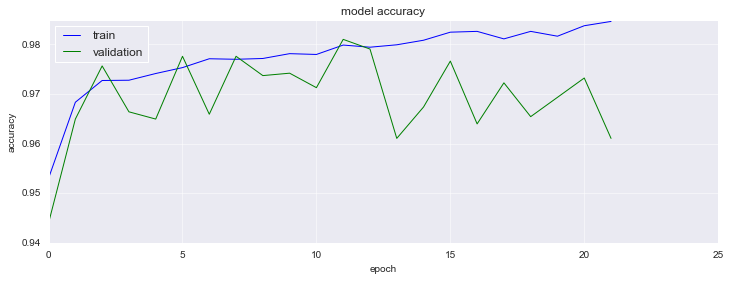

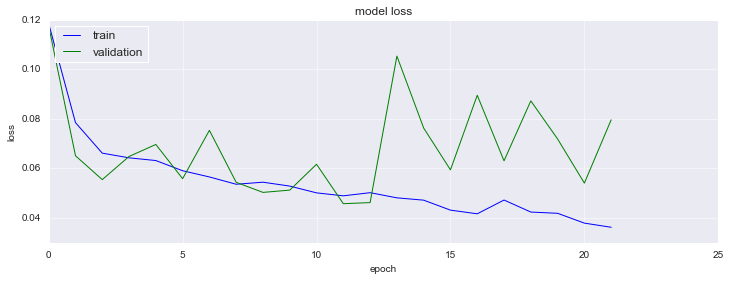

In [173]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

Conclusion: no hay un ajuste adecuado de las curvas de aprendizaje

In [174]:
print(history.history['loss'])

[0.11836030786462745, 0.07845905222272488, 0.06615163183930302, 0.06426186023640215, 0.06316705607825407, 0.05905800792637868, 0.05655317616513838, 0.0536066914699964, 0.05443568179973505, 0.05286597514004454, 0.050135311429958036, 0.0489403256593905, 0.0502082306434058, 0.048130277040826924, 0.047192136329387936, 0.043171819337313184, 0.04169347119053299, 0.04724177936119937, 0.0424011829289618, 0.0418955533102224, 0.03793544658902488, 0.036262839484222646]


In [175]:
# training metrics
scores = modelolstm2.evaluate(data_train, label_train, verbose=1, batch_size=1000)
print('Accurracy: {}'.format(scores[1]))

20531/20531 [==============================] - 2s 90us/step
Accurracy: 0.9837806271099265


In [176]:
label_pred2=modelolstm2.predict_classes(data_test)


Confusion Matrix: 
 [[12628    36]
 [   71   261]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9917666974453678
ROC AUC: 0.8916509372930763
------------------------------------------------------------
Precisión por clase: [0.99440901 0.87878788]
Sensibilidad - Recall por clase: [0.9971573  0.78614458]
F1 por clase: [0.99578126 0.82988871]
------------------------------------------------------------
F1 Macro: 0.912834984201101
F1 Micro: 0.9917666974453678
F1 Weighted: 0.9915433118252861
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8916509372930763
Sensibilidad - Recall Micro: 0.9917666974453678
Sensibilidad - Recall Weighted: 0.9917666974453678
------------------------------------------------------------
Precisión Macro: 0.9365984436856158
Precisión Micro: 0.9917666974453678
Precisión Weighted: 0.9914553139779284
------------------------------------------------------------
Verdaderos positivos - True Positives: 261
Verdadero

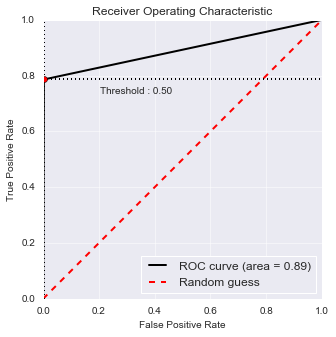

In [177]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, modelolstm2, label_pred2)

In [178]:
# evaluar probabilidad de falla
def prob_failure(machine_id):
    machine_df=test[test.id==machine_id]
    machine_test=gen_sequence(machine_df,secuencia,columnas_secuencia)
    m_pred=modelolstm2.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob

In [179]:
machine_id=16
print('Probability that machine will fail within 30 days: ',prob_failure(machine_id))

Probability that machine will fail within 30 days:  8.940697e-06


### Modelo 2

In [13]:
# arquitectura LSTM

model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(200, input_shape=(time_steps, features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=20, batch_size=128, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
print(history.history.keys())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 200)           180000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 300,501
Trainable params: 300,501
Non-trainab

KeyboardInterrupt: 

In [19]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

In [26]:
print(history.history['loss'])

[0.13730179691166952, 0.07494141893757623, 0.07414497529046776, 0.07014537741466748, 0.06366894882195129, 0.06368158343019485, 0.058075134532389334, 0.052117909110085354, 0.05432467173042817, 0.053374611115373526, 0.05198648175748969, 0.05294151994446955, 0.048820170257602435, 0.05486292848608988, 0.04977592997788841, 0.04901070092711129, 0.046863177943005555, 0.04453347016035391, 0.04840463278573713, 0.04471260058729526]


<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

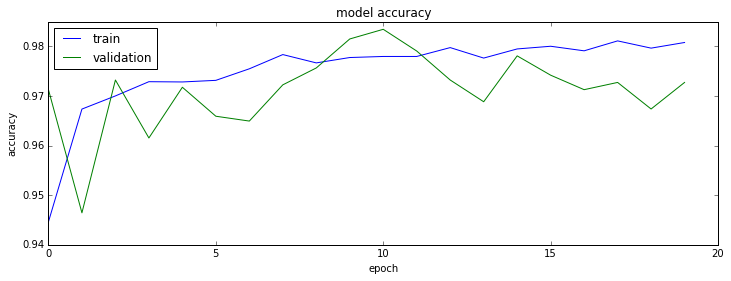

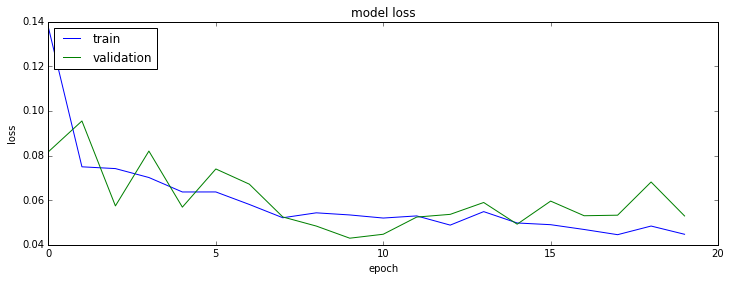

In [20]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

Conclusion: no hay un ajuste adecuado de las curvas de aprendizaje

In [21]:
label_pred=model.predict_classes(data_test)


In [22]:
# training metrics
scores = model.evaluate(data_test, label_test, verbose=1, batch_size=512)
print('Accurracy: {}'.format(scores[1]))

12996/12996 [==============================] - 2s 160us/step
Accurracy: 0.9913050170016677


In [27]:
print(scores)

[0.017369226320472313, 0.9913050170016677]


Confusion Matrix: 
 [[12639    25]
 [   88   244]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9913050169282857
ROC AUC: 0.8664828296128291
------------------------------------------------------------
Precisión por clase: [0.99308557 0.9070632 ]
Sensibilidad - Recall por clase: [0.9980259  0.73493976]
F1 por clase: [0.9955496  0.81198003]
------------------------------------------------------------
F1 Macro: 0.9037648187341657
F1 Micro: 0.9913050169282857
F1 Weighted: 0.9908600768325834
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8664828296128291
Sensibilidad - Recall Micro: 0.9913050169282857
Sensibilidad - Recall Weighted: 0.9913050169282857
------------------------------------------------------------
Precisión Macro: 0.9500743815726482
Precisión Micro: 0.9913050169282857
Precisión Weighted: 0.9908880109839278
------------------------------------------------------------
Verdaderos positivos - True Positives: 244
Verdader

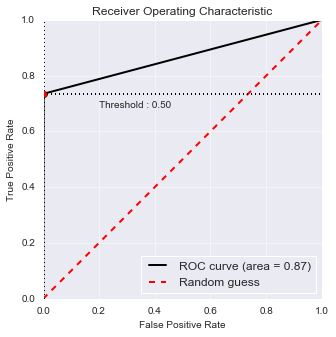

In [23]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

### Modelo 3

In [34]:
model_path_clf = 'classification_modelv2.h5'  
nb_features =data_train.shape[2]
time_steps =data_train.shape[1]

modelolstmv = Sequential()
modelolstmv.add(LSTM(70,input_shape=(time_steps, nb_features)))
modelolstmv.add(Dense(units=1, activation='sigmoid'))
modelolstmv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(modelolstmv.summary())

# fitting
history = modelolstmv.fit(data_train, label_train, epochs=100, batch_size=256, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 70)                26600     
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 71        
Total params: 26,671
Trainable params: 26,671
Non-trainable params: 0
_________________________________________________________________
None
Train on 18477 samples, validate on 2054 samples
Epoch 1/100
 - 16s - loss: 0.3266 - acc: 0.8842 - val_loss: 0.1499 - val_acc: 0.9391

Epoch 00001: val_loss improved from inf to 0.14988, saving model to classification_modelv2.h5
Epoch 2/100
 - 6s - loss: 0.1094 - acc: 0.9610 - val_loss: 0.1305 - val_acc: 0.9450

Epoch 00002: val_loss improved from 0.14988 to 0.13050, saving model to classification_modelv2.h5
Epoch 3/100
 - 6s - loss: 0.0894 - acc: 0.9656 - val_loss: 0.0933 - val_acc: 0.9518

Epoch 00003: val_loss improved f

In [35]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'test'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

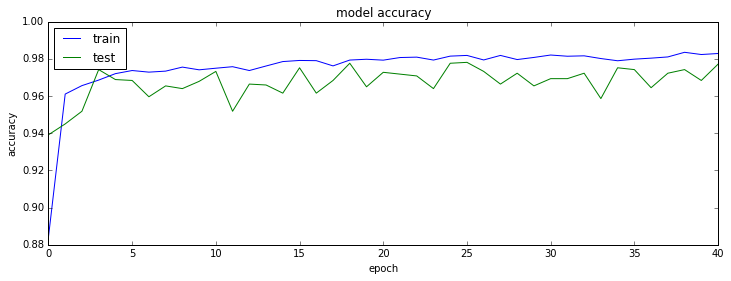

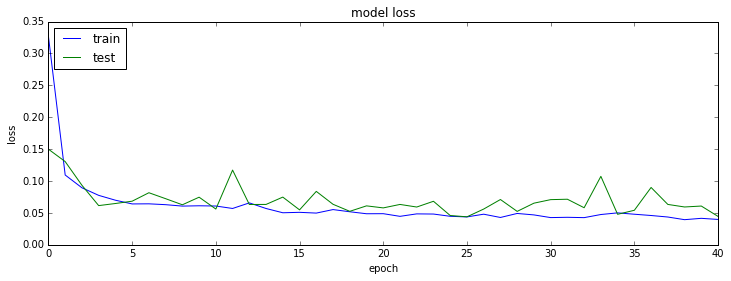

In [36]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

Cuando se incluyen el numero de celdas de memoria optimo mejora el ajuste en la curva de entrenamiento 

In [37]:
#evaluate the model
_, train_acc = modelolstmv.evaluate(data_train, label_train, verbose=1)
_, test_acc = modelolstmv.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 17s 1ms/step
Train: 0.984, Test: 0.992


In [38]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_modelv2.h5')

In [39]:
label_pred=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12641    23]
 [   87   245]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9915358571868267
ROC AUC: 0.8680678177016339
------------------------------------------------------------
Precisión por clase: [0.99316468 0.9141791 ]
Sensibilidad - Recall por clase: [0.99818383 0.73795181]
F1 por clase: [0.99566793 0.81666667]
------------------------------------------------------------
F1 Macro: 0.9061672967863894
F1 Micro: 0.9915358571868267
F1 Weighted: 0.9910951030834363
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8680678177016341
Sensibilidad - Recall Micro: 0.9915358571868267
Sensibilidad - Recall Weighted: 0.9915358571868267
------------------------------------------------------------
Precisión Macro: 0.9536718903909116
Precisión Micro: 0.9915358571868267
Precisión Weighted: 0.9911468854573022
------------------------------------------------------------
Verdaderos positivos - True Positives: 245
Verdader

C:\Users\alexh\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


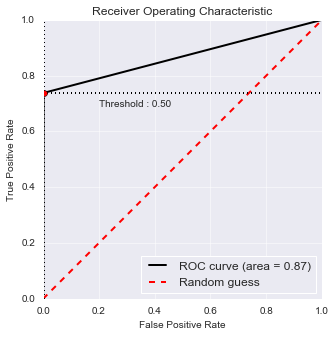

In [41]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred)

### Modelo 4

In [25]:
# Estructura para 4 capas ocultas LSTM:

# arquitectura LSTM

model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=20, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=20, batch_size=512, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
print(history.history.keys())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 40, 50)            15000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 40, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
___________________________

In [26]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

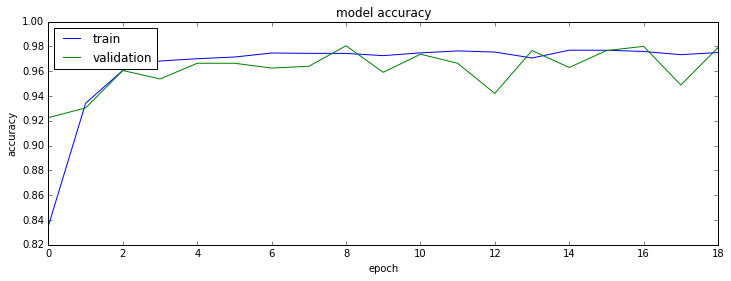

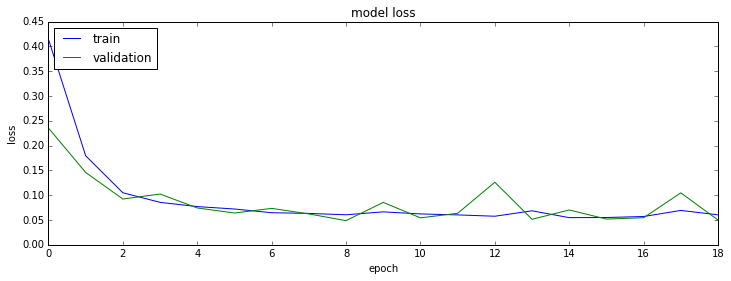

In [27]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [28]:
label_pred=model.predict_classes(data_test)

In [29]:
# training metrics
scores = model.evaluate(data_test, label_test, verbose=1, batch_size=512)
print('Accurracy: {}'.format(scores[1]))

12996/12996 [==============================] - 3s 215us/step
Accurracy: 0.9910741768531999


Confusion Matrix: 
 [[12641    23]
 [   93   239]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9910741766697445
ROC AUC: 0.8590316731233208
------------------------------------------------------------
Precisión por clase: [0.99269672 0.91221374]
Sensibilidad - Recall por clase: [0.99818383 0.71987952]
F1 por clase: [0.99543271 0.8047138 ]
------------------------------------------------------------
F1 Macro: 0.9000732579754549
F1 Micro: 0.9910741766697445
F1 Weighted: 0.9905605446500217
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8590316731233207
Sensibilidad - Recall Micro: 0.9910741766697445
Sensibilidad - Recall Weighted: 0.9910741766697445
------------------------------------------------------------
Precisión Macro: 0.9524552289536817
Precisión Micro: 0.9910741766697445
Precisión Weighted: 0.9906406734080183
------------------------------------------------------------
Verdaderos positivos - True Positives: 239
Verdader

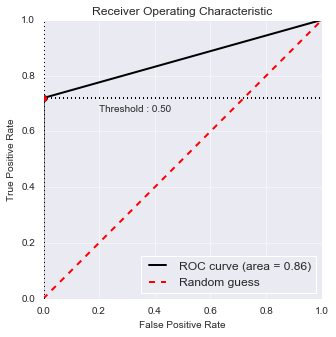

In [30]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

### Modelo 5

In [36]:
model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(200, input_shape=(time_steps, features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=512, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 40, 200)           180000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 200)           0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 40, 100)           120400    
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 40, 50)            30200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 50)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 10)                2440      
__________

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

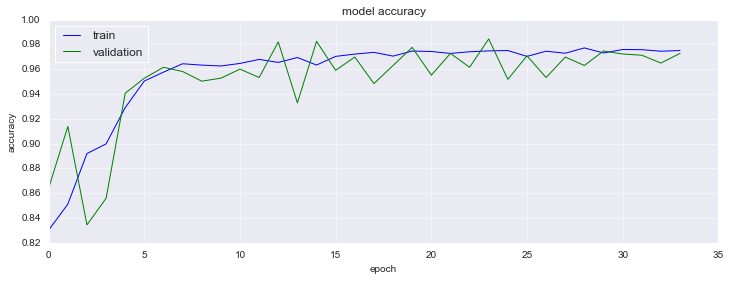

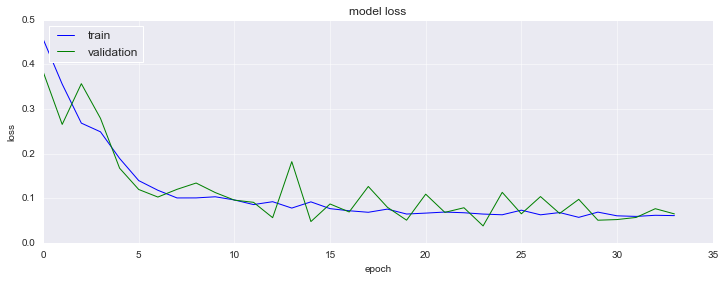

In [37]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [38]:
label_pred=model.predict_classes(data_test)

In [39]:
# training metrics
scores = model.evaluate(data_test, label_test, verbose=1, batch_size=512)
print('Accurracy: {}'.format(scores[1]))

12996/12996 [==============================] - 4s 291us/step
Accurracy: 0.9922283780725232


Confusion Matrix: 
 [[12611    53]
 [   48   284]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.99222837796245
ROC AUC: 0.9256182975743784
------------------------------------------------------------
Precisión por clase: [0.99620823 0.84272997]
Sensibilidad - Recall por clase: [0.99581491 0.85542169]
F1 por clase: [0.99601153 0.8490284 ]
------------------------------------------------------------
F1 Macro: 0.9225199658085694
F1 Micro: 0.99222837796245
F1 Weighted: 0.9922566526489731
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9256182975743783
Sensibilidad - Recall Micro: 0.99222837796245
Sensibilidad - Recall Weighted: 0.99222837796245
------------------------------------------------------------
Precisión Macro: 0.9194691008121502
Precisión Micro: 0.99222837796245
Precisión Weighted: 0.9922874262315218
------------------------------------------------------------
Verdaderos positivos - True Positives: 284
Verdaderos negativ

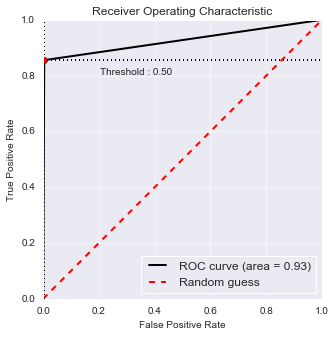

In [40]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

### Modelo 6

In [18]:
model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(300, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 40, 300)           390000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 300)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 40, 200)           400800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 200)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 40, 100)           120400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                30200     
__________

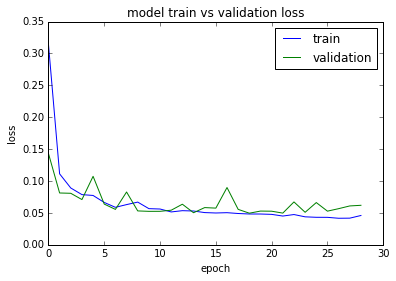

In [19]:
from matplotlib import pyplot

pyplot.plot(history.history[ 'loss' ])
pyplot.plot(history.history[ 'val_loss' ])
pyplot.title( 'model train vs validation loss' )
pyplot.ylabel( 'loss' )
pyplot.xlabel( 'epoch' )
pyplot.legend([ 'train' , 'validation' ], loc= 'upper right' )
pyplot.show()

In [20]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

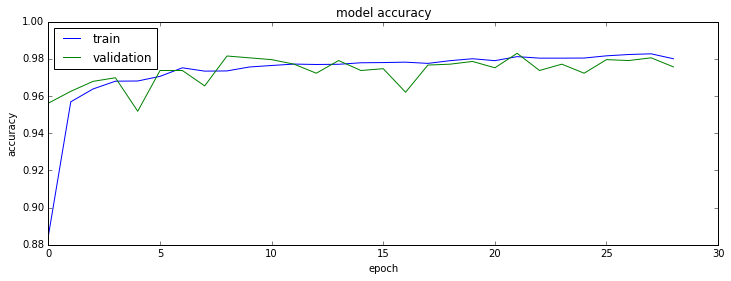

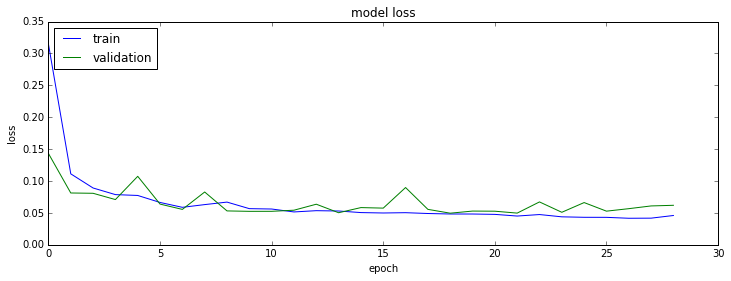

In [21]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

Se evidencia mejora en el ajuste de la curva de aprendizaje, Un buen ajuste es un caso en el que el rendimiento del modelo es bueno tanto en el train como en los conjuntos de validación. Esto se puede diagnosticar a partir de una trama donde el train y la pérdida de validación disminuyen y se estabilizan alrededor del mismo punto.

In [23]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')


In [24]:
#evaluate the model
_, train_acc = saved_model.evaluate(data_train, label_train, verbose=0)
_, test_acc = saved_model.evaluate(data_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.977, Test: 0.991


In [25]:
label_pred=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12649    15]
 [  107   225]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9906124961526623
ROC AUC: 0.838263191743601
------------------------------------------------------------
Precisión por clase: [0.99161179 0.9375    ]
Sensibilidad - Recall por clase: [0.99881554 0.67771084]
F1 por clase: [0.99520063 0.78671329]
------------------------------------------------------------
F1 Macro: 0.8909569580694678
F1 Micro: 0.9906124961526623
F1 Weighted: 0.9898745446472168
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.838263191743601
Sensibilidad - Recall Micro: 0.9906124961526623
Sensibilidad - Recall Weighted: 0.9906124961526623
------------------------------------------------------------
Precisión Macro: 0.9645558952649733
Precisión Micro: 0.9906124961526623
Precisión Weighted: 0.9902294333080367
------------------------------------------------------------
Verdaderos positivos - True Positives: 225
Verdaderos

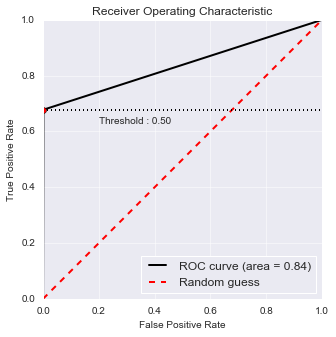

In [26]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred)

In [27]:
label_pred2=model.predict_classes(data_test)

Confusion Matrix: 
 [[12623    41]
 [   79   253]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9907663896583564
ROC AUC: 0.8794053345409434
------------------------------------------------------------
Precisión por clase: [0.99378051 0.86054422]
Sensibilidad - Recall por clase: [0.99676248 0.76204819]
F1 por clase: [0.99526926 0.80830671]
------------------------------------------------------------
F1 Macro: 0.9017879836635743
F1 Micro: 0.9907663896583564
F1 Weighted: 0.9904930525987121
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8794053345409434
Sensibilidad - Recall Micro: 0.9907663896583564
Sensibilidad - Recall Weighted: 0.9907663896583564
------------------------------------------------------------
Precisión Macro: 0.9271623623469227
Precisión Micro: 0.9907663896583564
Precisión Weighted: 0.9903768098650239
------------------------------------------------------------
Verdaderos positivos - True Positives: 253
Verdader

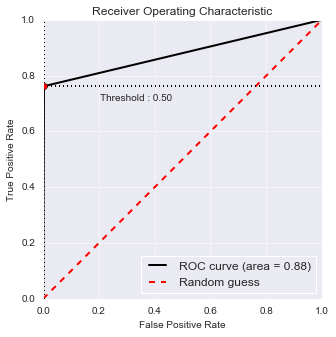

In [29]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred2)

### Modelo 7

In [30]:
model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=128, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 40, 50)            15000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 40, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total para

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

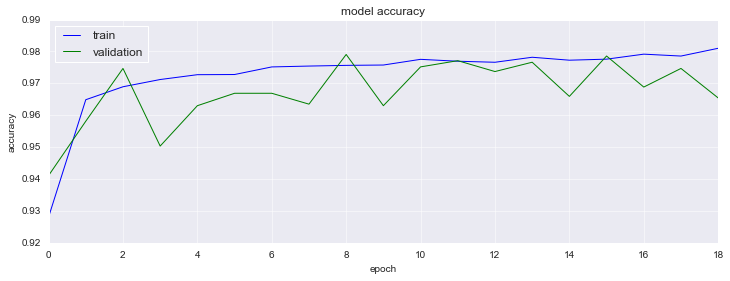

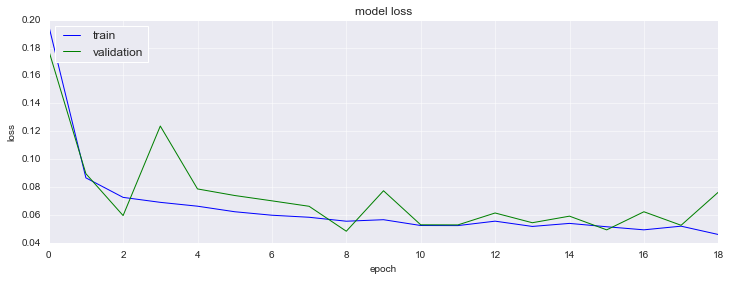

In [31]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

## Arquitecturas ajustando tamaño de lote

### Modelo 8

In [14]:
model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(100, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 40, 100)           50000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 40, 50)            30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 40, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 50)            0         
___________________________

In [15]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

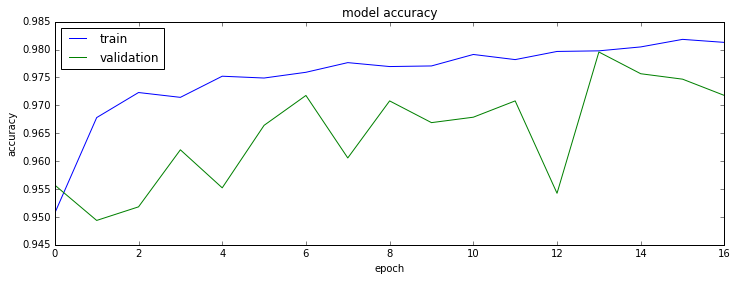

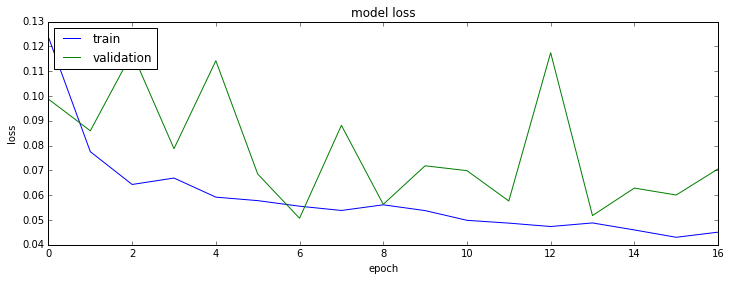

In [16]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

Underfit: Un modelo de falta de ajuste es aquel que se ha demostrado que funciona bien en el conjunto de datos de entrenamiento y pobre en el conjunto de datos de prueba.

Esto se puede diagnosticar a partir de una gráfica en la que la pérdida de entrenamiento es menor que la pérdida de validación, y la pérdida de validación tiene una tendencia que sugiere que son posibles mejoras adicionales.

### Modelo 9

In [17]:
model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(300, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 40, 300)           390000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 300)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 40, 200)           400800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 200)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 40, 100)           120400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                30200     
__________

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

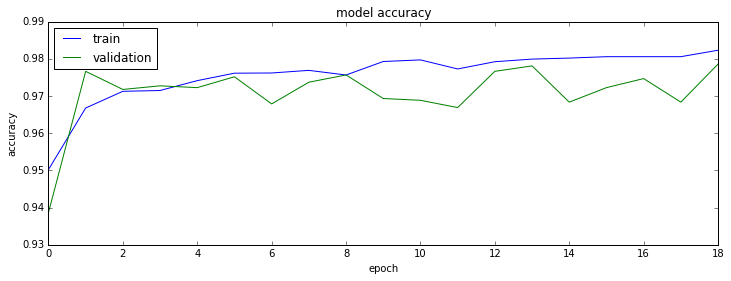

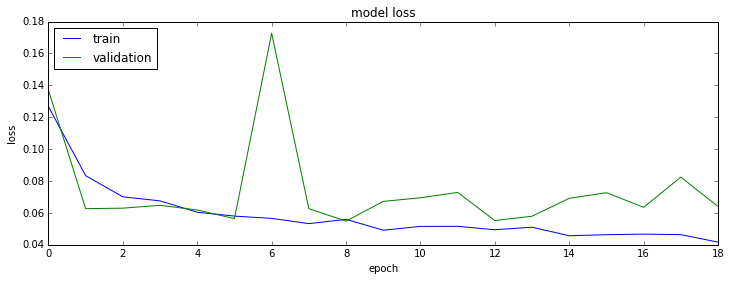

In [18]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [19]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')


In [20]:
#evaluate the model
_, train_acc = saved_model.evaluate(data_train, label_train, verbose=0)
_, test_acc = saved_model.evaluate(data_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.980, Test: 0.992


In [21]:
label_pred=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12638    26]
 [   75   257]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.99222837796245
ROC AUC: 0.8860216608696313
------------------------------------------------------------
Precisión por clase: [0.99410053 0.90812721]
Sensibilidad - Recall por clase: [0.99794694 0.77409639]
F1 por clase: [0.99602002 0.83577236]
------------------------------------------------------------
F1 Macro: 0.9158961879251136
F1 Micro: 0.99222837796245
F1 Weighted: 0.991926279803026
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8860216608696314
Sensibilidad - Recall Micro: 0.99222837796245
Sensibilidad - Recall Weighted: 0.99222837796245
------------------------------------------------------------
Precisión Macro: 0.9511138677500759
Precisión Micro: 0.99222837796245
Precisión Weighted: 0.9919042249454899
------------------------------------------------------------
Verdaderos positivos - True Positives: 257
Verdaderos negativo

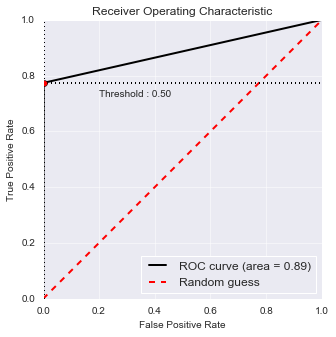

In [22]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred)

In [23]:
label_pred2=model.predict_classes(data_test)

Confusion Matrix: 
 [[12636    28]
 [   58   274]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9933825792551554
ROC AUC: 0.9115451065157663
------------------------------------------------------------
Precisión por clase: [0.99543091 0.90728477]
Sensibilidad - Recall por clase: [0.99778901 0.8253012 ]
F1 por clase: [0.99660857 0.86435331]
------------------------------------------------------------
F1 Macro: 0.9304809388235546
F1 Micro: 0.9933825792551554
F1 Weighted: 0.9932299300711281
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9115451065157663
Sensibilidad - Recall Micro: 0.9933825792551554
Sensibilidad - Recall Weighted: 0.9933825792551554
------------------------------------------------------------
Precisión Macro: 0.9513578402269622
Precisión Micro: 0.9933825792551554
Precisión Weighted: 0.9931791024683825
------------------------------------------------------------
Verdaderos positivos - True Positives: 274
Verdader

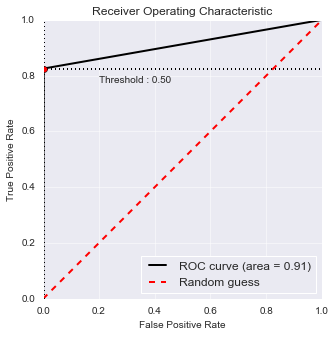

In [24]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred2)

## Prueba multiples repeticiones del modelo

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 18477 samples, validate on 2054 samples
Epoch 1/30
18477/18477 [==============================] - 155s 8ms/step - loss: 0.1396 - acc: 0.9446 - val_loss: 0.0851 - val_acc: 0.9562
Epoch 2/30
18477/18477 [==============================] - 152s 8ms/step - loss: 0.0824 - acc: 0.9647 - val_loss: 0.0641 - val_acc: 0.9713
Epoch 3/30
18477/18477 [==============================] - 152s 8ms/step - loss: 0.0672 - acc: 0.9719 - val_loss: 0.0758 - val_acc: 0.9615
Epoch 4/30
18477/18477 [==============================] - 152s 8ms/step - loss: 0.0695 - acc: 0.9698 - val_loss: 0.0701 - val_acc: 0.9630
Epoch 5/30
18477/18477 [==============================] - 152s 8ms/step - loss: 0.0595 - acc: 0.9763 - val_loss: 0.0724 - val_acc: 0.9620
Epoch 6/30
18477/18477 [==============================] - 152s 8ms/step - loss: 0.0583 - acc: 0.9767 - val_loss: 0.0578 - val_acc: 0.9684
Epoch 7/

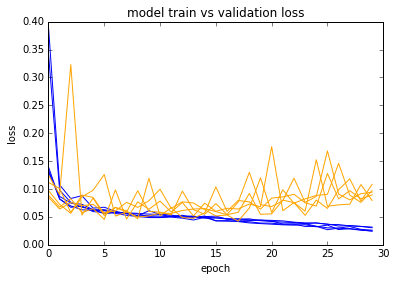

In [16]:
# collect data across multiple repeats 5 repeticiones

train = DataFrame()
val = DataFrame()
features =data_train.shape[2]
time_steps =data_train.shape[1]

for i in range(5):
    # define model
    model = Sequential()
    model.add(LSTM(300, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
    model.add(Dropout(0.2))
    model.add(LSTM(200, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    history = model.fit(data_train, label_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)
    # story history
    train[str(i)] = history.history[ 'loss' ]
    val[str(i)] = history.history[ 'val_loss' ]
    
# plot train and validation loss across multiple runs
pyplot.plot(train, color= 'blue' , label= 'train' )
pyplot.plot(val, color= 'orange' , label= 'validation' )
pyplot.title( 'model train vs validation loss' )
pyplot.ylabel( 'loss' )
pyplot.xlabel( 'epoch' )
pyplot.show()

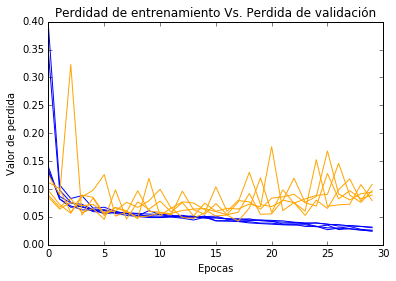

In [21]:

# plot train and validation loss across multiple runs
pyplot.plot(train, color= 'blue' , label= 'train' )
pyplot.plot(val, color= 'orange' , label= 'validation' )
pyplot.title( 'Perdidad de entrenamiento Vs. Perdida de validación')
pyplot.ylabel( 'Valor de perdida' )
pyplot.xlabel( 'Epocas' )
plt.savefig('box3.png')
pyplot.show()

En la grafica se evidencia Overfit, un modelo sobreajustado es aquel en el que el rendimiento en el conjunto de train es bueno y continúa mejorando, mientras que el rendimiento en el conjunto de validación mejora hasta cierto punto y luego comienza a degradarse.

Esto se puede diagnosticar a partir de un diagrama donde la pérdida del train desciende y la pérdida de validación desciende, golpea un punto de inflexión y comienza a subir nuevamente.

### Modelo 10

In [15]:
model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(300, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=128, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 40, 300)           390000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 40, 200)           400800    
_________________________________________________________________
lstm_15 (LSTM)               (None, 40, 100)           120400    
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 941,451
Trainable params: 941,451
Non-trainable params: 0
_________________________________________________________________
None
Train on 18477 samples, validate on 2054 samples
Epoch 1/100
 - 49s - loss: 0.4216 - acc: 0.8478 - val_loss: 0.4164 - val_acc: 0.86

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

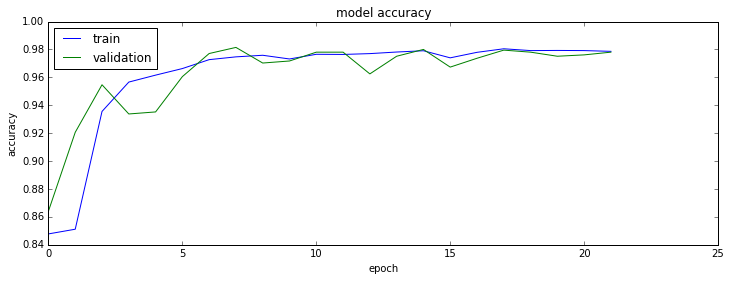

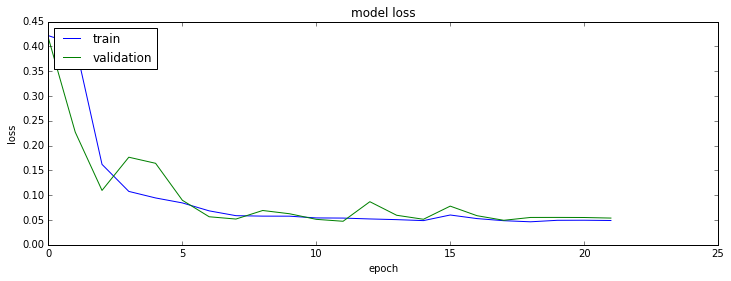

In [17]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

se presenta un buen ajuste, es un caso en el que el rendimiento del modelo es bueno tanto en el train como en los conjuntos de validación.

Esto se puede diagnosticar a partir de una trama donde el train y la pérdida de validación disminuyen y se estabilizan alrededor del mismo punto.

In [18]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=0)
_, test_acc = model.evaluate(data_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.982, Test: 0.991


In [19]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12613    51]
 [   68   264]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9908433364112035
ROC AUC: 0.895576779639087
------------------------------------------------------------
Precisión por clase: [0.99463765 0.83809524]
Sensibilidad - Recall por clase: [0.99597284 0.79518072]
F1 por clase: [0.99530479 0.81607419]
------------------------------------------------------------
F1 Macro: 0.9056894912037682
F1 Micro: 0.9908433364112035
F1 Weighted: 0.9907261110999616
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.895576779639087
Sensibilidad - Recall Micro: 0.9908433364112035
Sensibilidad - Recall Weighted: 0.9908433364112035
------------------------------------------------------------
Precisión Macro: 0.9163664424842566
Precisión Micro: 0.9908433364112035
Precisión Weighted: 0.990638564100552
------------------------------------------------------------
Verdaderos positivos - True Positives: 264
Verdaderos 

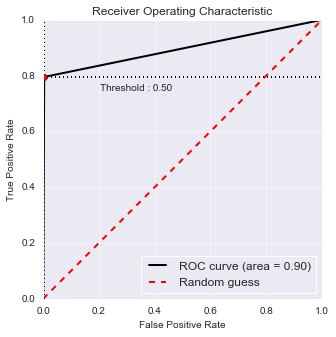

In [20]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

### Modelo 11

In [21]:
model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(30, return_sequences= False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=128, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 40, 300)           390000    
_________________________________________________________________
dropout_13 (Dropout)         (None, 40, 300)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 40, 200)           400800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 40, 200)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 40, 100)           120400    
_________________________________________________________________
dropout_15 (Dropout)         (None, 40, 100)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                30200     
__________

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

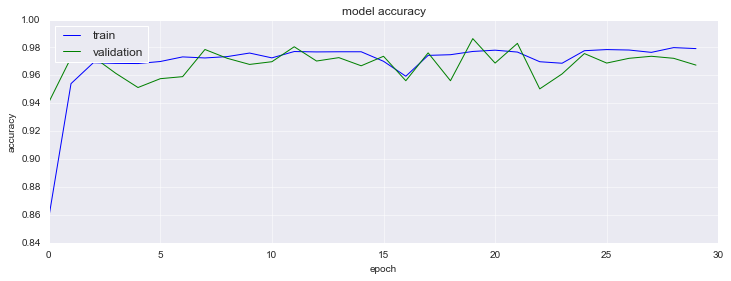

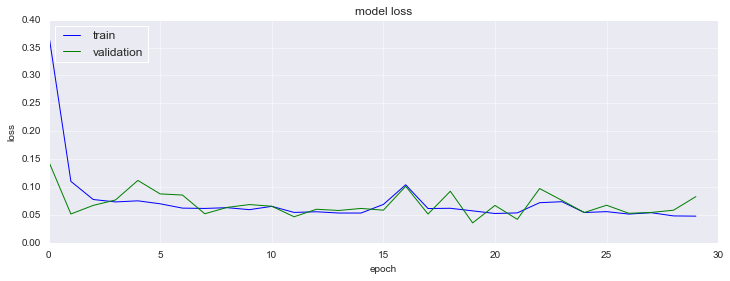

In [22]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [23]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12629    35]
 [   66   266]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.99222837796245
ROC AUC: 0.8992205397712136
------------------------------------------------------------
Precisión por clase: [0.9948011  0.88372093]
Sensibilidad - Recall por clase: [0.99723626 0.80120482]
F1 por clase: [0.99601719 0.84044234]
------------------------------------------------------------
F1 Macro: 0.9182297655898267
F1 Micro: 0.99222837796245
F1 Weighted: 0.9920428277736972
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8992205397712136
Sensibilidad - Recall Micro: 0.99222837796245
Sensibilidad - Recall Weighted: 0.99222837796245
------------------------------------------------------------
Precisión Macro: 0.9392610165144674
Precisión Micro: 0.99222837796245
Precisión Weighted: 0.9919634129463314
------------------------------------------------------------
Verdaderos positivos - True Positives: 266
Verdaderos negativ

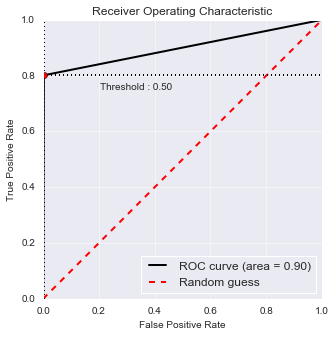

In [24]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

### Modelo 12

In [27]:
from keras import optimizers

model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(300, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
sgd = optimizers.SGD(lr=0.001, momentum=0.3)
model.compile(loss='binary_crossentropy', optimizer= sgd, metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=128, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 40, 300)           390000    
_________________________________________________________________
dropout_21 (Dropout)         (None, 40, 300)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 40, 200)           400800    
_________________________________________________________________
dropout_22 (Dropout)         (None, 40, 200)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 40, 100)           120400    
_________________________________________________________________
dropout_23 (Dropout)         (None, 40, 100)           0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 50)                30200     
__________

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

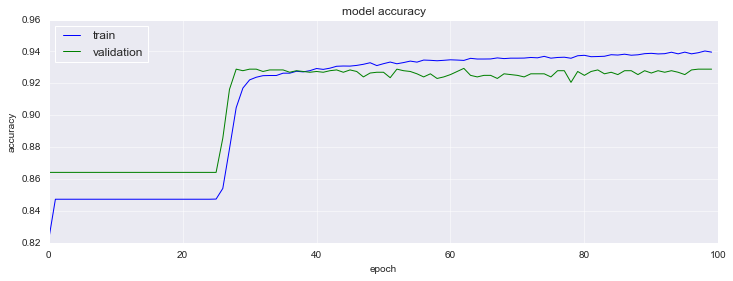

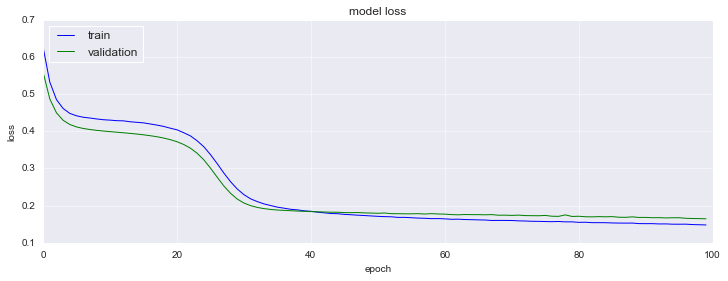

In [28]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [29]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12599    65]
 [  179   153]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9812249923053247
ROC AUC: 0.7278553569933556
------------------------------------------------------------
Precisión por clase: [0.98599155 0.70183486]
Sensibilidad - Recall por clase: [0.99486734 0.46084337]
F1 por clase: [0.99040956 0.55636364]
------------------------------------------------------------
F1 Macro: 0.7733865976802853
F1 Micro: 0.9812249923053247
F1 Weighted: 0.9793212821183365
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.7278553569933556
Sensibilidad - Recall Micro: 0.9812249923053247
Sensibilidad - Recall Weighted: 0.9812249923053247
------------------------------------------------------------
Precisión Macro: 0.8439132051792
Precisión Micro: 0.9812249923053247
Precisión Weighted: 0.9787323898001689
------------------------------------------------------------
Verdaderos positivos - True Positives: 153
Verdaderos 

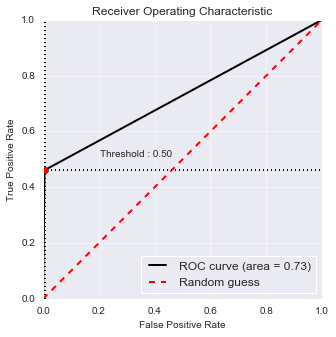

In [30]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

### Modelo 13

In [31]:
model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]

model = Sequential()
model.add(LSTM(300, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 40, 300)           390000    
_________________________________________________________________
dropout_25 (Dropout)         (None, 40, 300)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 40, 200)           400800    
_________________________________________________________________
dropout_26 (Dropout)         (None, 40, 200)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 40, 100)           120400    
_________________________________________________________________
dropout_27 (Dropout)         (None, 40, 100)           0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 50)                30200     
__________

In [32]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')


In [33]:
#evaluate the model
_, train_acc = saved_model.evaluate(data_train, label_train, verbose=0)
_, test_acc = saved_model.evaluate(data_test, label_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.978, Test: 0.991


In [34]:
label_pred=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12657     7]
 [  106   226]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9913050169282857
ROC AUC: 0.8400850718096645
------------------------------------------------------------
Precisión por clase: [0.99169474 0.96995708]
Sensibilidad - Recall por clase: [0.99944725 0.68072289]
F1 por clase: [0.99555591 0.8       ]
------------------------------------------------------------
F1 Macro: 0.8977779525701026
F1 Micro: 0.9913050169282857
F1 Weighted: 0.9905601710292059
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8400850718096644
Sensibilidad - Recall Micro: 0.9913050169282857
Sensibilidad - Recall Weighted: 0.9913050169282857
------------------------------------------------------------
Precisión Macro: 0.9808259120802185
Precisión Micro: 0.9913050169282857
Precisión Weighted: 0.9911394253273346
------------------------------------------------------------
Verdaderos positivos - True Positives: 226
Verdader

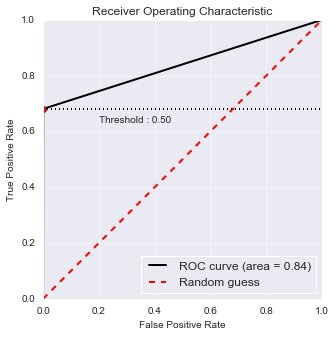

In [35]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred)

In [36]:
label_pred2=model.predict_classes(data_test)

Confusion Matrix: 
 [[12620    44]
 [   77   255]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9906894429055094
ROC AUC: 0.8822989367450852
------------------------------------------------------------
Precisión por clase: [0.99393558 0.85284281]
Sensibilidad - Recall por clase: [0.99652558 0.76807229]
F1 por clase: [0.99522889 0.80824089]
------------------------------------------------------------
F1 Macro: 0.9017348911199303
F1 Micro: 0.9906894429055094
F1 Weighted: 0.9904520389258148
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8822989367450852
Sensibilidad - Recall Micro: 0.9906894429055094
Sensibilidad - Recall Weighted: 0.9906894429055094
------------------------------------------------------------
Precisión Macro: 0.9233891923486521
Precisión Micro: 0.9906894429055094
Precisión Weighted: 0.9903311741091911
------------------------------------------------------------
Verdaderos positivos - True Positives: 255
Verdader

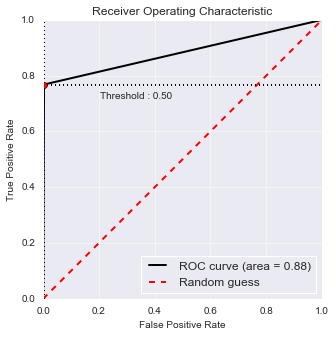

In [37]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred2)

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

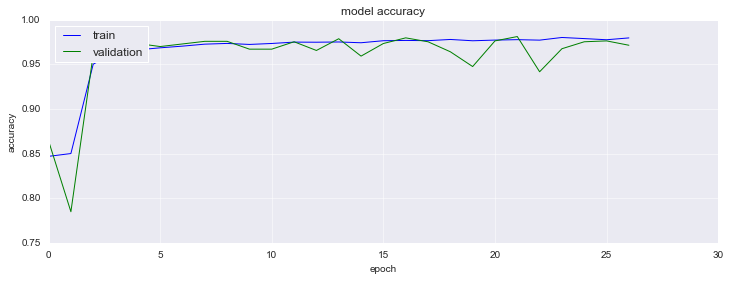

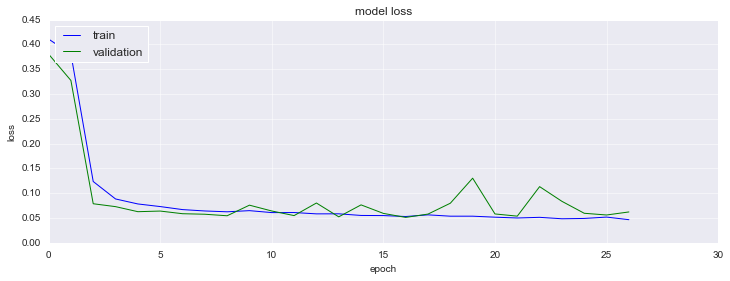

In [38]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

### Modelo 14

In [14]:
model_path_clf = 'classification_model1s.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(50, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=64, validation_split=0.2, verbose=2, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 40, 70)            26600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 70)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40, 50)            24200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
______________________________________________

In [19]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

In [15]:
print(history.history['loss'])

[4.43015912086628, 0.34986611569270354, 0.2934819509706669, 0.26246111461492616, 0.24982680882614414, 0.24663195964829027, 0.22267059803996153, 0.21822836913832558, 0.21252601939587842, 0.20651310438419979, 0.19807170922298636, 0.19377672657755254, 0.18849953439647374, 0.19349246852814833, 0.19140989006770512, 0.18010141234164465, 0.17380865999709322, 0.1676813737610405, 0.1611135239230675, 0.1596120690143927, 0.16684082548573606, 0.1592419618260727, 0.1464164248194511, 0.1489050470281681, 0.15296118577631054, 0.15026076832632873, 0.1432092717172341, 0.13734958609371029, 0.14310982075773446]


<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

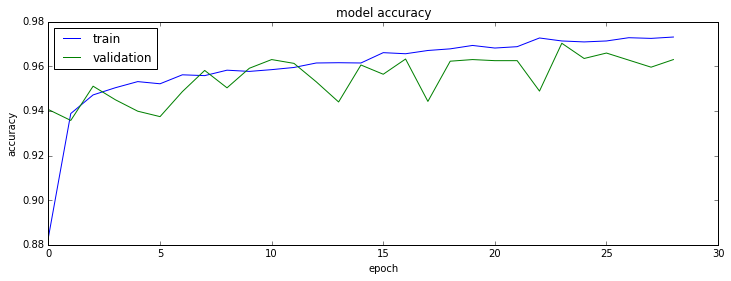

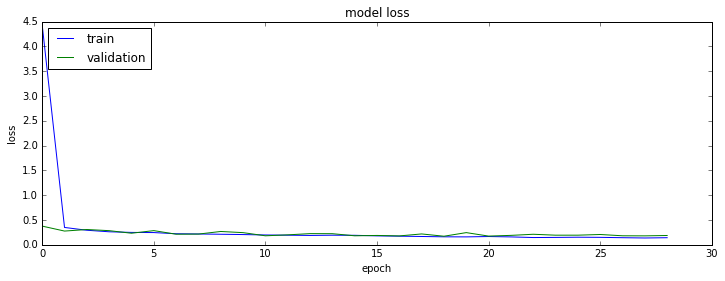

In [16]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [17]:
label_pred=model.predict_classes(data_test)


In [18]:
# training metrics
scores = model.evaluate(data_test, label_test, verbose=1, batch_size=512)
print('Accurracy: {}'.format(scores[1]))

12996/12996 [==============================] - 3s 206us/step
Accurracy: 0.9875346261488543


In [19]:
print(scores)

[0.07449101452351937, 0.9875346261488543]


Confusion Matrix: 
 [[12524   140]
 [   22   310]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9875346260387812
ROC AUC: 0.961339990410156
------------------------------------------------------------
Precisión por clase: [0.99824645 0.68888889]
Sensibilidad - Recall por clase: [0.98894504 0.93373494]
F1 por clase: [0.99357398 0.79283887]
------------------------------------------------------------
F1 Macro: 0.8932064266301178
F1 Micro: 0.9875346260387812
F1 Weighted: 0.9884459349900029
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.961339990410156
Sensibilidad - Recall Micro: 0.9875346260387812
Sensibilidad - Recall Weighted: 0.9875346260387812
------------------------------------------------------------
Precisión Macro: 0.8435676709708273
Precisión Micro: 0.9875346260387812
Precisión Weighted: 0.9903435051224483
------------------------------------------------------------
Verdaderos positivos - True Positives: 310
Verdaderos

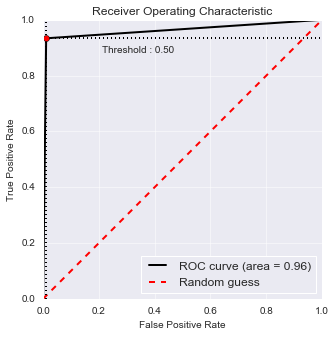

In [20]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

### Modelo 15

In [13]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(100, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(50, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(25, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=40, batch_size=32, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 100)           50000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40, 50)            30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                7600      
___________________________________________________________

In [14]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

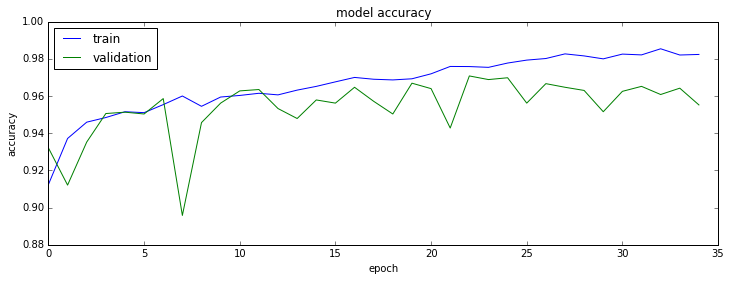

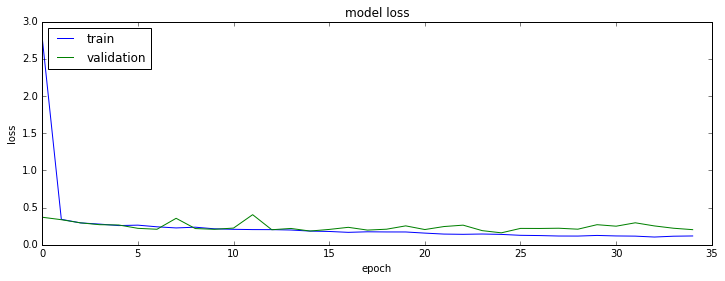

In [15]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [16]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 43s 3ms/step
Train: 0.974, Test: 0.988


In [17]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12546   118]
 [   34   298]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9883040935672515
ROC AUC: 0.9441363051701436
------------------------------------------------------------
Precisión por clase: [0.9972973  0.71634615]
Sensibilidad - Recall por clase: [0.99068225 0.89759036]
F1 por clase: [0.99397877 0.79679144]
------------------------------------------------------------
F1 Macro: 0.8953851055410424
F1 Micro: 0.9883040935672515
F1 Weighted: 0.9889413563851973
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9441363051701436
Sensibilidad - Recall Micro: 0.9883040935672515
Sensibilidad - Recall Weighted: 0.9883040935672515
------------------------------------------------------------
Precisión Macro: 0.8568217255717256
Precisión Micro: 0.9883040935672515
Precisión Weighted: 0.9901200289358184
------------------------------------------------------------
Verdaderos positivos - True Positives: 298
Verdader

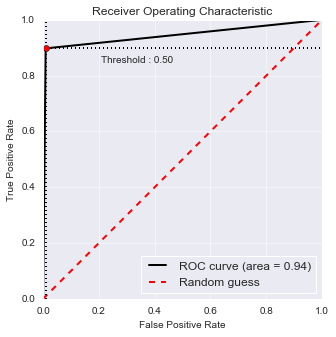

In [18]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [19]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [20]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12578    86]
 [   45   287]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9899199753770391
ROC AUC: 0.928833463988614
------------------------------------------------------------
Precisión por clase: [0.99643508 0.769437  ]
Sensibilidad - Recall por clase: [0.9932091  0.86445783]
F1 por clase: [0.99481947 0.8141844 ]
------------------------------------------------------------
F1 Macro: 0.9045019348096617
F1 Micro: 0.9899199753770391
F1 Weighted: 0.9902049106681676
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.928833463988614
Sensibilidad - Recall Micro: 0.9899199753770391
Sensibilidad - Recall Weighted: 0.9899199753770391
------------------------------------------------------------
Precisión Macro: 0.8829360380717015
Precisión Micro: 0.9899199753770391
Precisión Weighted: 0.990636112753287
------------------------------------------------------------
Verdaderos positivos - True Positives: 287
Verdaderos 

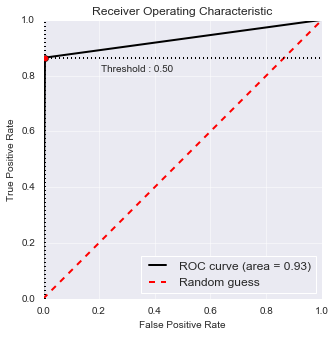

In [21]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 16

In [22]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(30, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(20, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(10, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=40, batch_size=64, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 40, 30)            6600      
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 30)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40, 20)            4080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 20)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total para

In [23]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

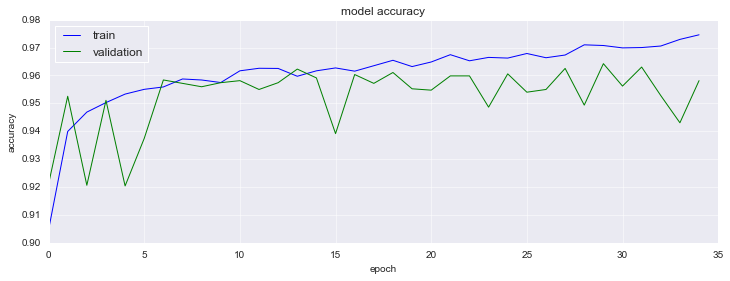

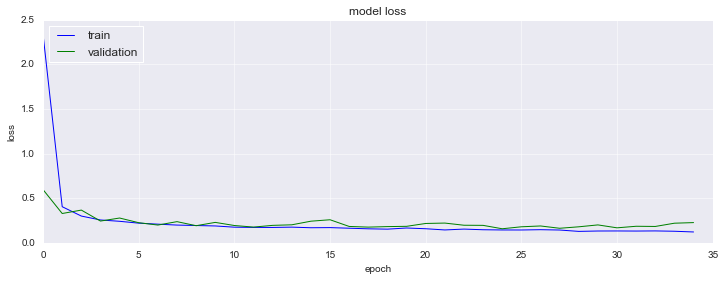

In [24]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [25]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 43s 3ms/step
Train: 0.971, Test: 0.990


In [26]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12589    75]
 [   61   271]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9895352416128039
ROC AUC: 0.9051713804047522
------------------------------------------------------------
Precisión por clase: [0.99517787 0.78323699]
Sensibilidad - Recall por clase: [0.9940777  0.81626506]
F1 por clase: [0.99462748 0.79941003]
------------------------------------------------------------
F1 Macro: 0.8970187541819874
F1 Micro: 0.9895352416128039
F1 Weighted: 0.9896403910545989
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9051713804047523
Sensibilidad - Recall Micro: 0.9895352416128039
Sensibilidad - Recall Weighted: 0.9895352416128039
------------------------------------------------------------
Precisión Macro: 0.8892074299161508
Precisión Micro: 0.9895352416128039
Precisión Weighted: 0.9897635558786936
------------------------------------------------------------
Verdaderos positivos - True Positives: 271
Verdader

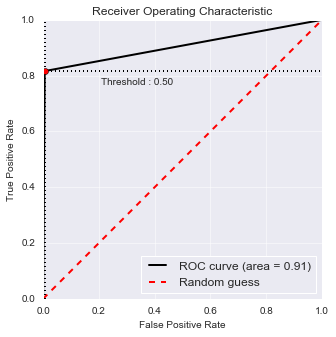

In [27]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [28]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [29]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12590    74]
 [   41   291]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9911511234225916
ROC AUC: 0.9353313443286728
------------------------------------------------------------
Precisión por clase: [0.99675402 0.79726027]
Sensibilidad - Recall por clase: [0.99415666 0.87650602]
F1 por clase: [0.99545365 0.83500717]
------------------------------------------------------------
F1 Macro: 0.9152304102834756
F1 Micro: 0.9911511234225916
F1 Weighted: 0.9913548297022559
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9353313443286728
Sensibilidad - Recall Micro: 0.9911511234225916
Sensibilidad - Recall Weighted: 0.9911511234225916
------------------------------------------------------------
Precisión Macro: 0.8970071459325447
Precisión Micro: 0.9911511234225916
Precisión Weighted: 0.9916576864842533
------------------------------------------------------------
Verdaderos positivos - True Positives: 291
Verdader

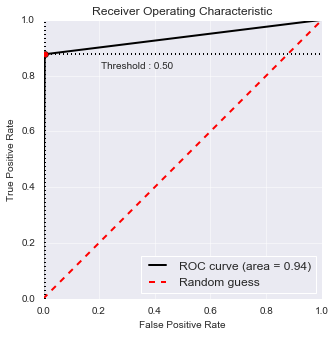

In [30]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 17

In [31]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(200, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(100, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(50, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 40, 200)           180000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 200)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 40, 100)           120400    
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total para

In [32]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

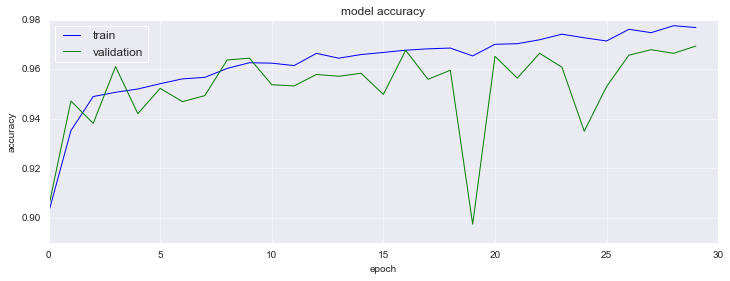

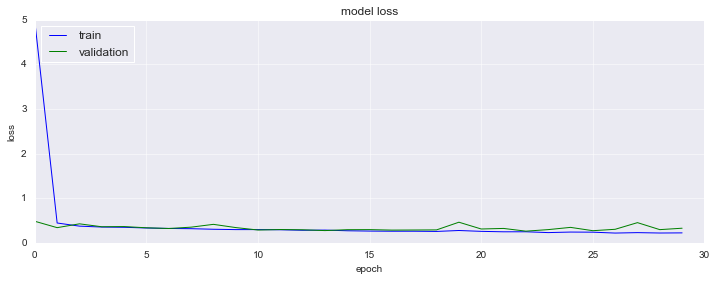

In [33]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [34]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 44s 3ms/step
Train: 0.985, Test: 0.990


In [35]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12606    58]
 [   67   265]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9903816558941213
ROC AUC: 0.8968064297620045
------------------------------------------------------------
Precisión por clase: [0.99471317 0.82043344]
Sensibilidad - Recall por clase: [0.99542009 0.79819277]
F1 por clase: [0.9950665  0.80916031]
------------------------------------------------------------
F1 Macro: 0.9021134044379475
F1 Micro: 0.9903816558941213
F1 Weighted: 0.9903172839418397
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8968064297620044
Sensibilidad - Recall Micro: 0.9903816558941213
Sensibilidad - Recall Weighted: 0.9903816558941213
------------------------------------------------------------
Precisión Macro: 0.9075733031317159
Precisión Micro: 0.9903816558941213
Precisión Weighted: 0.9902609635581113
------------------------------------------------------------
Verdaderos positivos - True Positives: 265
Verdader

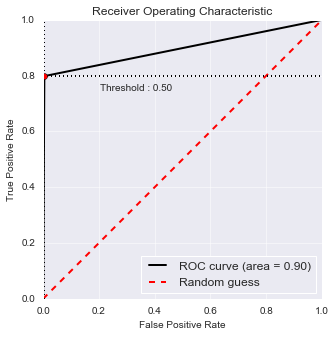

In [36]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [37]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [38]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12560   104]
 [   25   307]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9900738688827332
ROC AUC: 0.9582432699845497
------------------------------------------------------------
Precisión por clase: [0.99801351 0.74695864]
Sensibilidad - Recall por clase: [0.99178774 0.9246988 ]
F1 por clase: [0.99489089 0.82637954]
------------------------------------------------------------
F1 Macro: 0.910635214581743
F1 Micro: 0.9900738688827332
F1 Weighted: 0.9905860417130424
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9582432699845497
Sensibilidad - Recall Micro: 0.9900738688827332
Sensibilidad - Recall Weighted: 0.9900738688827332
------------------------------------------------------------
Precisión Macro: 0.8724860728071016
Precisión Micro: 0.9900738688827332
Precisión Weighted: 0.9915999795924383
------------------------------------------------------------
Verdaderos positivos - True Positives: 307
Verdadero

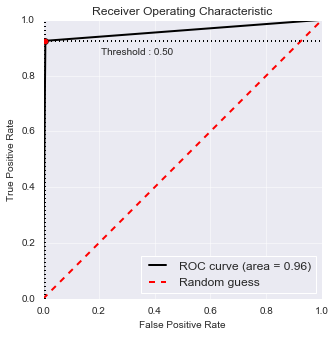

In [39]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 18

In [40]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=128, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 1.13611, saving model to classification_model.h5

Epoch 00002: val_loss improved from 1.1

In [41]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

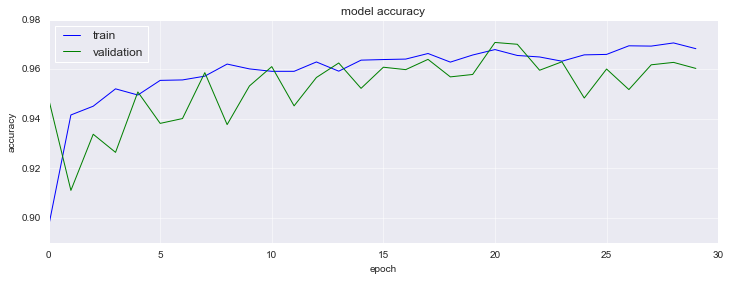

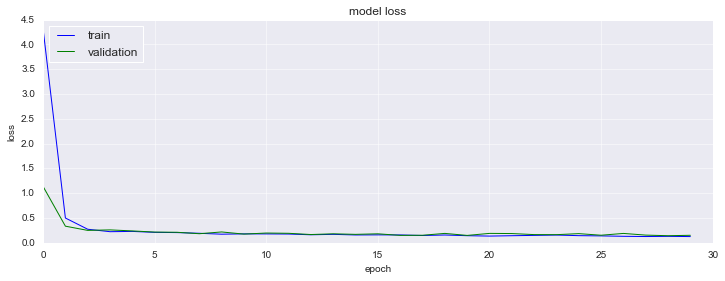

In [42]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [43]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.971, Test: 0.991


In [44]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12580    84]
 [   35   297]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9908433364112035
ROC AUC: 0.9439726689448888
------------------------------------------------------------
Precisión por clase: [0.99722553 0.77952756]
Sensibilidad - Recall por clase: [0.99336702 0.89457831]
F1 por clase: [0.99529254 0.83309958]
------------------------------------------------------------
F1 Macro: 0.9141960572743109
F1 Micro: 0.9908433364112035
F1 Weighted: 0.991149101833145
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9439726689448888
Sensibilidad - Recall Micro: 0.9908433364112035
Sensibilidad - Recall Weighted: 0.9908433364112035
------------------------------------------------------------
Precisión Macro: 0.8883765421117842
Precisión Micro: 0.9908433364112035
Precisión Weighted: 0.9916641428393009
------------------------------------------------------------
Verdaderos positivos - True Positives: 297
Verdadero

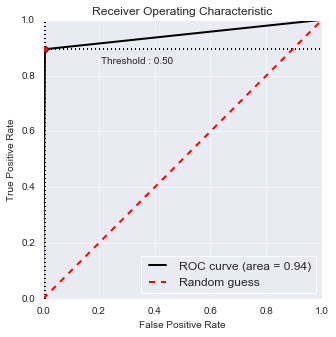

In [45]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [46]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [47]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12589    75]
 [   39   293]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9912280701754386
ROC AUC: 0.9383039105252342
------------------------------------------------------------
Precisión por clase: [0.99691162 0.79619565]
Sensibilidad - Recall por clase: [0.9940777  0.88253012]
F1 por clase: [0.99549265 0.83714286]
------------------------------------------------------------
F1 Macro: 0.9163177515193963
F1 Micro: 0.9912280701754386
F1 Weighted: 0.9914473912124927
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9383039105252342
Sensibilidad - Recall Micro: 0.9912280701754386
Sensibilidad - Recall Weighted: 0.9912280701754386
------------------------------------------------------------
Precisión Macro: 0.8965536385671593
Precisión Micro: 0.9912280701754386
Precisión Weighted: 0.9917840701000549
------------------------------------------------------------
Verdaderos positivos - True Positives: 293
Verdader

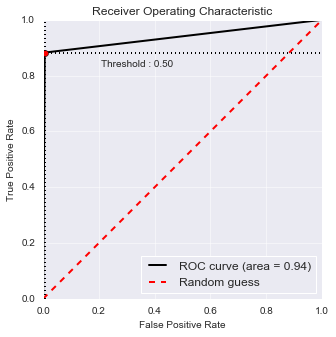

In [48]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 19

In [49]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(50, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(25, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 40, 50)            15000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 40, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 25)                7600      
_________________________________________________________________
dropout_13 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 22,626
Trainable params: 22,626
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.20172, saving model to classification_model.h5

Epoch 00002: val_loss improved from 0.2

In [50]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

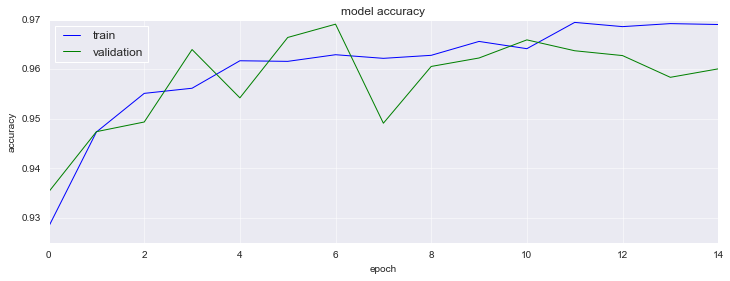

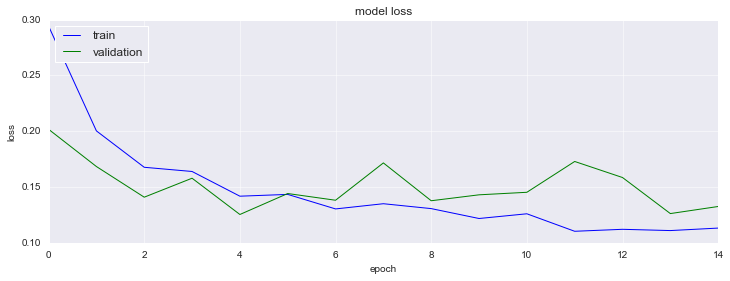

In [51]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [52]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 29s 2ms/step
Train: 0.969, Test: 0.989


In [53]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12540   124]
 [   23   309]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9886888273314867
ROC AUC: 0.9604656782531262
------------------------------------------------------------
Precisión por clase: [0.99816923 0.71362587]
Sensibilidad - Recall por clase: [0.99020846 0.93072289]
F1 por clase: [0.99417291 0.80784314]
------------------------------------------------------------
F1 Macro: 0.9010080236161536
F1 Micro: 0.9886888273314867
F1 Weighted: 0.9894128696154575
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9604656782531262
Sensibilidad - Recall Micro: 0.9886888273314867
Sensibilidad - Recall Weighted: 0.9886888273314867
------------------------------------------------------------
Precisión Macro: 0.8558975465731237
Precisión Micro: 0.9886888273314867
Precisión Weighted: 0.9909001907868197
------------------------------------------------------------
Verdaderos positivos - True Positives: 309
Verdader

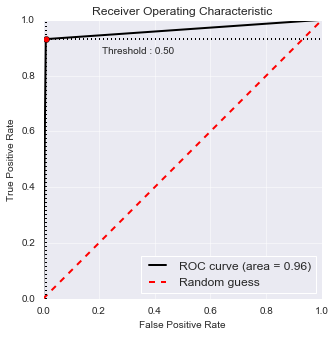

In [54]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [55]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [56]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12515   149]
 [   18   314]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.987149892274546
ROC AUC: 0.9670087488298107
------------------------------------------------------------
Precisión por clase: [0.99856379 0.67818575]
Sensibilidad - Recall por clase: [0.98823437 0.94578313]
F1 por clase: [0.99337223 0.78993711]
------------------------------------------------------------
F1 Macro: 0.891654666885321
F1 Micro: 0.987149892274546
F1 Weighted: 0.9881752077836017
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9670087488298107
Sensibilidad - Recall Micro: 0.987149892274546
Sensibilidad - Recall Weighted: 0.987149892274546
------------------------------------------------------------
Precisión Macro: 0.8383747683652953
Precisión Micro: 0.987149892274546
Precisión Weighted: 0.9903793108714164
------------------------------------------------------------
Verdaderos positivos - True Positives: 314
Verdaderos neg

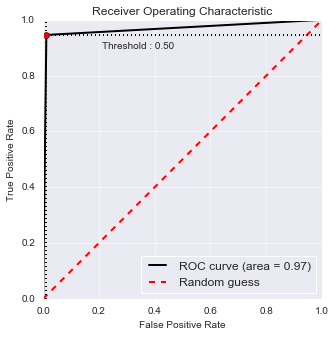

In [57]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 20

In [58]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_14 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_15 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.25888, saving model to classification_model.h5

Epoch 00002: val_loss improved from 0.2

In [59]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

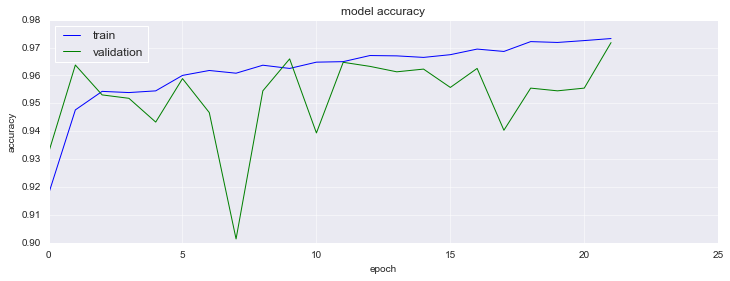

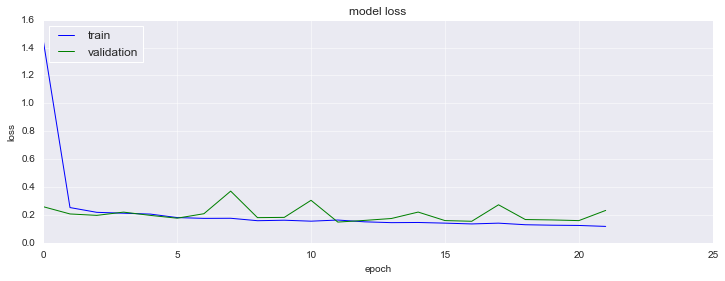

In [60]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [61]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 29s 2ms/step
Train: 0.983, Test: 0.991


In [62]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12625    39]
 [   79   253]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9909202831640505
ROC AUC: 0.8794842985333629
------------------------------------------------------------
Precisión por clase: [0.99378149 0.86643836]
Sensibilidad - Recall por clase: [0.9969204  0.76204819]
F1 por clase: [0.99534847 0.81089744]
------------------------------------------------------------
F1 Macro: 0.9031229532057348
F1 Micro: 0.9909202831640505
F1 Weighted: 0.9906364250005901
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.8794842985333629
Sensibilidad - Recall Micro: 0.9909202831640505
Sensibilidad - Recall Weighted: 0.9909202831640505
------------------------------------------------------------
Precisión Macro: 0.9301099211552397
Precisión Micro: 0.9909202831640505
Precisión Weighted: 0.9905283375500716
------------------------------------------------------------
Verdaderos positivos - True Positives: 253
Verdader

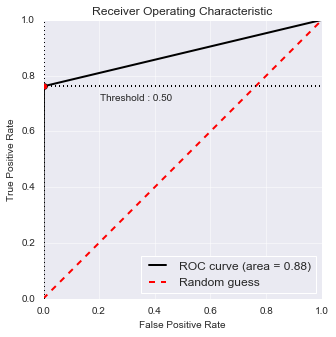

In [63]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [64]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [65]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12573    91]
 [   33   299]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9904586026469683
ROC AUC: 0.946708343164192
------------------------------------------------------------
Precisión por clase: [0.9973822  0.76666667]
Sensibilidad - Recall por clase: [0.99281428 0.90060241]
F1 por clase: [0.995093   0.82825485]
------------------------------------------------------------
F1 Macro: 0.9116739216462209
F1 Micro: 0.9904586026469683
F1 Weighted: 0.9908308946054206
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9467083431641918
Sensibilidad - Recall Micro: 0.9904586026469683
Sensibilidad - Recall Weighted: 0.9904586026469683
------------------------------------------------------------
Precisión Macro: 0.8820244328097732
Precisión Micro: 0.9904586026469683
Precisión Weighted: 0.9914882656873345
------------------------------------------------------------
Verdaderos positivos - True Positives: 299
Verdadero

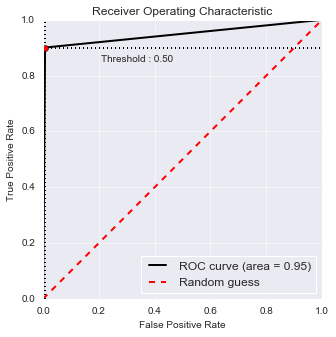

In [66]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 21

In [67]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=128, validation_split=0.1, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_16 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_17 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.77383, saving model to classification_model.h5

Epoch 00002: val_loss improved from 0.7

In [68]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

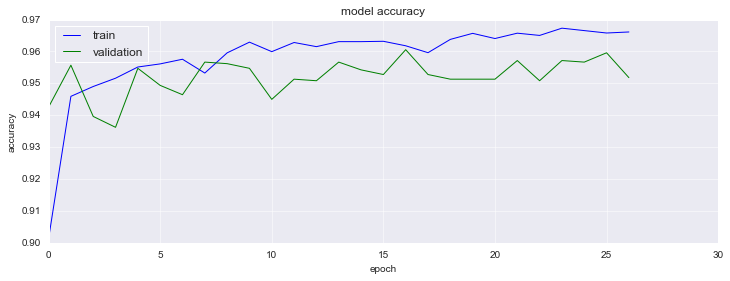

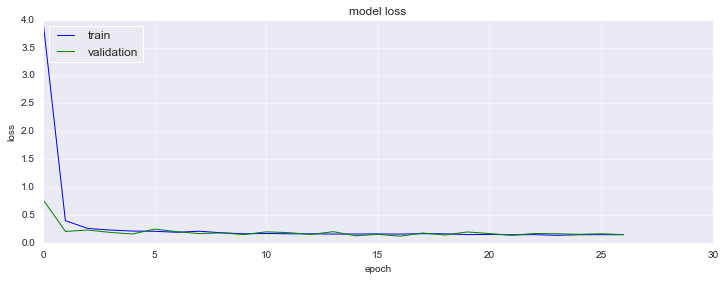

In [69]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [70]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.968, Test: 0.988


In [71]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12557   107]
 [   44   288]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9883810403200985
ROC AUC: 0.9295103661645953
------------------------------------------------------------
Precisión por clase: [0.99650821 0.72911392]
Sensibilidad - Recall por clase: [0.99155085 0.86746988]
F1 por clase: [0.99402335 0.79229711]
------------------------------------------------------------
F1 Macro: 0.893160231940332
F1 Micro: 0.9883810403200985
F1 Weighted: 0.9888699889652957
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9295103661645951
Sensibilidad - Recall Micro: 0.9883810403200985
Sensibilidad - Recall Weighted: 0.9883810403200985
------------------------------------------------------------
Precisión Macro: 0.8628110688422357
Precisión Micro: 0.9883810403200985
Precisión Weighted: 0.9896772730258343
------------------------------------------------------------
Verdaderos positivos - True Positives: 288
Verdadero

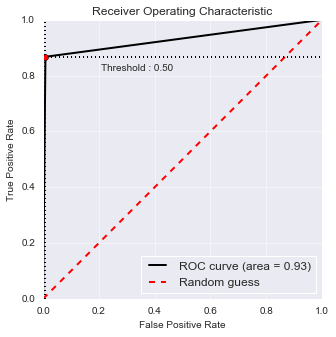

In [72]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [73]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [74]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12593    71]
 [   55   277]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9903047091412742
ROC AUC: 0.9143654529679046
------------------------------------------------------------
Precisión por clase: [0.99565149 0.79597701]
Sensibilidad - Recall por clase: [0.99439356 0.83433735]
F1 por clase: [0.99502212 0.81470588]
------------------------------------------------------------
F1 Macro: 0.9048640031233732
F1 Micro: 0.9903047091412742
F1 Weighted: 0.9904157071354515
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9143654529679045
Sensibilidad - Recall Micro: 0.9903047091412742
Sensibilidad - Recall Weighted: 0.9903047091412742
------------------------------------------------------------
Precisión Macro: 0.8958142489476324
Precisión Micro: 0.9903047091412742
Precisión Weighted: 0.9905505379808024
------------------------------------------------------------
Verdaderos positivos - True Positives: 277
Verdader

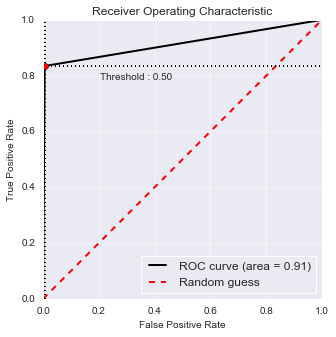

In [75]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 22

In [76]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=64, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_18 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_19 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.31047, saving model to classification_model.h5

Epoch 00002: val_loss improved from 0.3

In [77]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

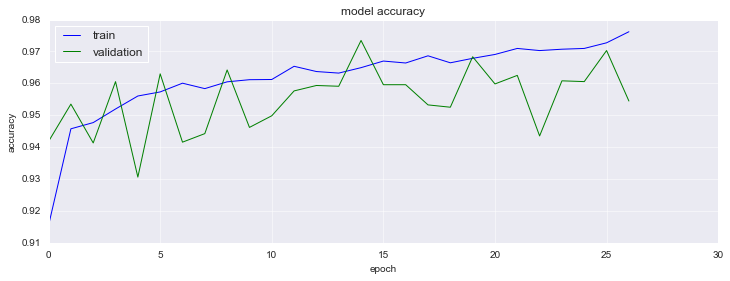

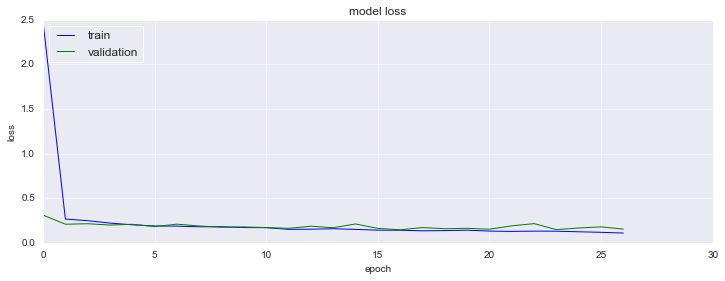

In [78]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [79]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.962, Test: 0.986


In [80]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12494   170]
 [   10   322]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9861495844875346
ROC AUC: 0.9782278196804908
------------------------------------------------------------
Precisión por clase: [0.99920026 0.65447154]
Sensibilidad - Recall por clase: [0.98657612 0.96987952]
F1 por clase: [0.99284806 0.7815534 ]
------------------------------------------------------------
F1 Macro: 0.8872007295440658
F1 Micro: 0.9861495844875345
F1 Weighted: 0.9874502595443004
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9782278196804908
Sensibilidad - Recall Micro: 0.9861495844875346
Sensibilidad - Recall Weighted: 0.9861495844875346
------------------------------------------------------------
Precisión Macro: 0.8268359003167767
Precisión Micro: 0.9861495844875346
Precisión Weighted: 0.9903937052779644
------------------------------------------------------------
Verdaderos positivos - True Positives: 322
Verdader

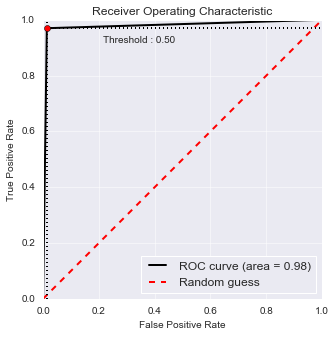

In [81]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [82]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [83]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12550   114]
 [   28   304]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9890735610957218
ROC AUC: 0.9533303777332957
------------------------------------------------------------
Precisión por clase: [0.99777389 0.72727273]
Sensibilidad - Recall por clase: [0.9909981  0.91566265]
F1 por clase: [0.99437446 0.81066667]
------------------------------------------------------------
F1 Macro: 0.9025205609698123
F1 Micro: 0.9890735610957218
F1 Weighted: 0.9896813969613782
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9533303777332958
Sensibilidad - Recall Micro: 0.9890735610957218
Sensibilidad - Recall Weighted: 0.9890735610957218
------------------------------------------------------------
Precisión Macro: 0.8625233090966913
Precisión Micro: 0.9890735610957218
Precisión Weighted: 0.9908635811075504
------------------------------------------------------------
Verdaderos positivos - True Positives: 304
Verdader

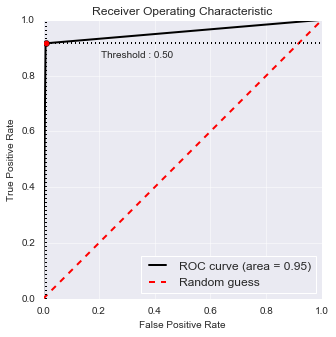

In [84]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 23

In [85]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=128, validation_split=0.1, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_20 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_21 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.83388, saving model to classification_model.h5

Epoch 00002: val_loss improved from 0.8

In [86]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

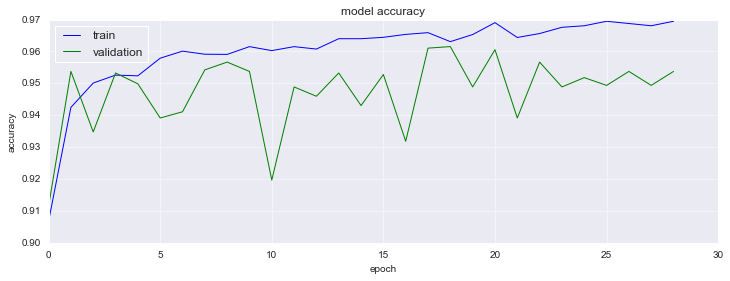

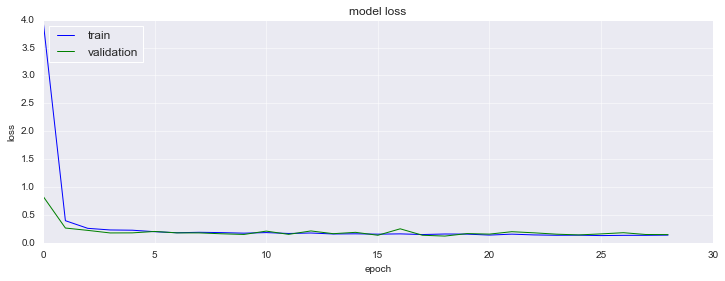

In [87]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [88]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.971, Test: 0.989


In [89]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12557   107]
 [   30   302]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.989458294859957
ROC AUC: 0.9505947035139927
------------------------------------------------------------
Precisión por clase: [0.99761659 0.73838631]
Sensibilidad - Recall por clase: [0.99155085 0.90963855]
F1 por clase: [0.99457447 0.81511471]
------------------------------------------------------------
F1 Macro: 0.9048445910748394
F1 Micro: 0.989458294859957
F1 Weighted: 0.9899899354304551
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9505947035139928
Sensibilidad - Recall Micro: 0.989458294859957
Sensibilidad - Recall Weighted: 0.989458294859957
------------------------------------------------------------
Precisión Macro: 0.8680014483060976
Precisión Micro: 0.989458294859957
Precisión Weighted: 0.990994208340766
------------------------------------------------------------
Verdaderos positivos - True Positives: 302
Verdaderos neg

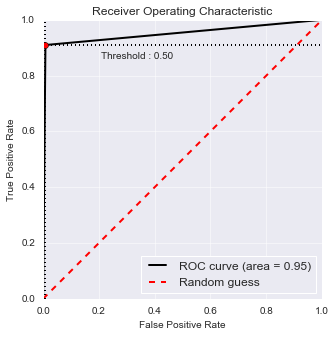

In [90]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [91]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [92]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12569    95]
 [   46   286]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9891505078485688
ROC AUC: 0.9269721019263408
------------------------------------------------------------
Precisión por clase: [0.99635355 0.75065617]
Sensibilidad - Recall por clase: [0.99249842 0.86144578]
F1 por clase: [0.99442225 0.80224404]
------------------------------------------------------------
F1 Macro: 0.8983331434930911
F1 Micro: 0.9891505078485688
F1 Weighted: 0.9895128013317096
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9269721019263408
Sensibilidad - Recall Micro: 0.9891505078485688
Sensibilidad - Recall Weighted: 0.9891505078485688
------------------------------------------------------------
Precisión Macro: 0.8735048576716258
Precisión Micro: 0.9891505078485688
Precisión Weighted: 0.990076883009378
------------------------------------------------------------
Verdaderos positivos - True Positives: 286
Verdadero

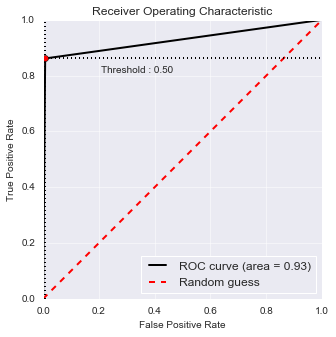

In [93]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 24

In [94]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_22 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_23 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.28874, saving model to classification_model.h5

Epoch 00002: val_loss improved from 0.2

In [95]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

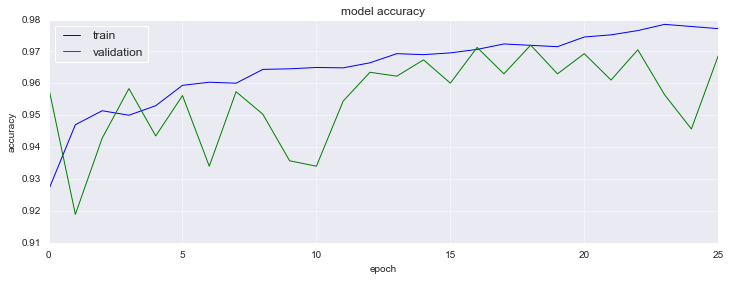

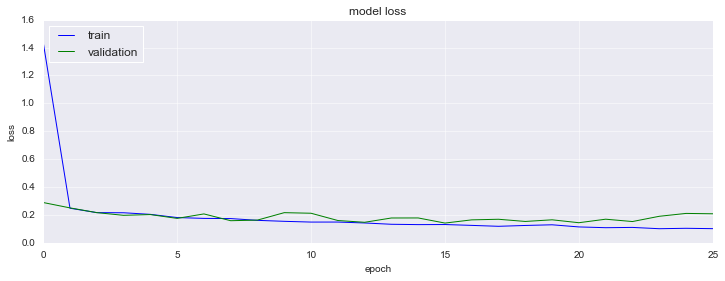

In [96]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [97]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.984, Test: 0.991


In [98]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12600    64]
 [   50   282]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9912280701754386
ROC AUC: 0.9221719474233002
------------------------------------------------------------
Precisión por clase: [0.99604743 0.8150289 ]
Sensibilidad - Recall por clase: [0.9949463  0.84939759]
F1 por clase: [0.99549656 0.83185841]
------------------------------------------------------------
F1 Macro: 0.9136774851231366
F1 Micro: 0.9912280701754386
F1 Weighted: 0.9913162101487081
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9221719474233003
Sensibilidad - Recall Micro: 0.9912280701754386
Sensibilidad - Recall Weighted: 0.9912280701754386
------------------------------------------------------------
Precisión Macro: 0.9055381662820718
Precisión Micro: 0.9912280701754386
Precisión Weighted: 0.9914230732077056
------------------------------------------------------------
Verdaderos positivos - True Positives: 282
Verdader

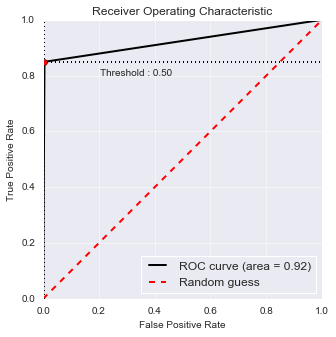

In [99]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [100]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [101]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12560   104]
 [   29   303]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9897660818713451
ROC AUC: 0.9522191735990075
------------------------------------------------------------
Precisión por clase: [0.9976964  0.74447174]
Sensibilidad - Recall por clase: [0.99178774 0.9126506 ]
F1 por clase: [0.9947333  0.82002706]
------------------------------------------------------------
F1 Macro: 0.9073801813067187
F1 Micro: 0.9897660818713451
F1 Weighted: 0.990270197278243
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9522191735990075
Sensibilidad - Recall Micro: 0.9897660818713451
Sensibilidad - Recall Weighted: 0.9897660818713451
------------------------------------------------------------
Precisión Macro: 0.8710840730461034
Precisión Micro: 0.9897660818713451
Precisión Weighted: 0.9912274430044747
------------------------------------------------------------
Verdaderos positivos - True Positives: 303
Verdadero

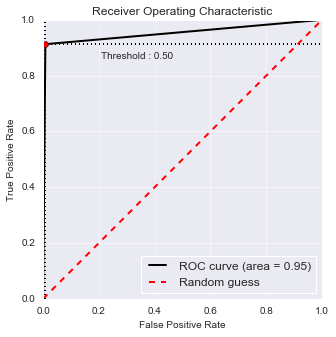

In [102]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 25

In [103]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_24 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_25 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.25683, saving model to classification_model.h5

Epoch 00002: val_loss improved from 0.2

In [104]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

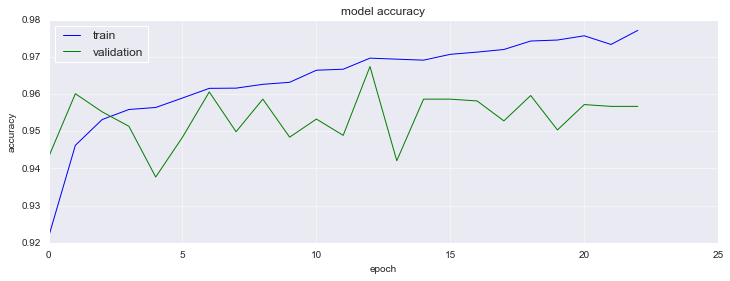

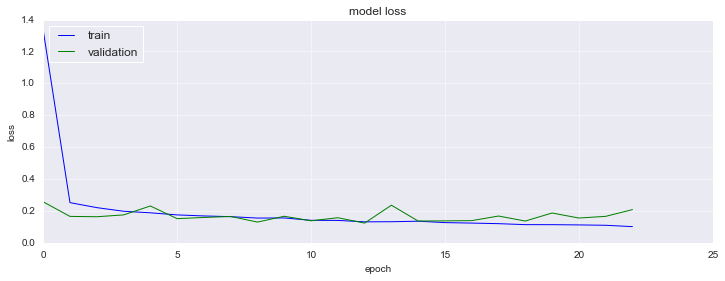

In [105]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [106]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.979, Test: 0.990


In [107]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12576    88]
 [   39   293]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9902277623884272
ROC AUC: 0.9377906445745076
------------------------------------------------------------
Precisión por clase: [0.99690844 0.76902887]
Sensibilidad - Recall por clase: [0.99305117 0.88253012]
F1 por clase: [0.99497607 0.82187938]
------------------------------------------------------------
F1 Macro: 0.9084277249902311
F1 Micro: 0.9902277623884272
F1 Weighted: 0.9905540834689867
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9377906445745077
Sensibilidad - Recall Micro: 0.9902277623884272
Sensibilidad - Recall Weighted: 0.9902277623884272
------------------------------------------------------------
Precisión Macro: 0.8829686568608175
Precisión Micro: 0.9902277623884272
Precisión Weighted: 0.9910869574466016
------------------------------------------------------------
Verdaderos positivos - True Positives: 293
Verdader

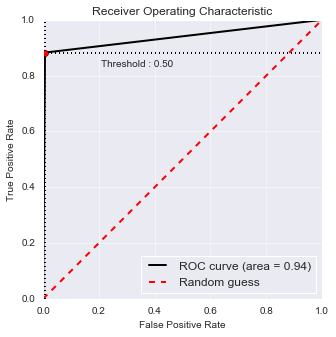

In [108]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [109]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [110]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12545   119]
 [   23   309]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9890735610957218
ROC AUC: 0.9606630882341749
------------------------------------------------------------
Precisión por clase: [0.99816996 0.72196262]
Sensibilidad - Recall por clase: [0.99060328 0.93072289]
F1 por clase: [0.99437223 0.81315789]
------------------------------------------------------------
F1 Macro: 0.9037650602409638
F1 Micro: 0.9890735610957218
F1 Weighted: 0.9897428661040626
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9606630882341749
Sensibilidad - Recall Micro: 0.9890735610957218
Sensibilidad - Recall Weighted: 0.9890735610957218
------------------------------------------------------------
Precisión Macro: 0.8600662861324117
Precisión Micro: 0.9890735610957218
Precisión Weighted: 0.9911138738463771
------------------------------------------------------------
Verdaderos positivos - True Positives: 309
Verdader

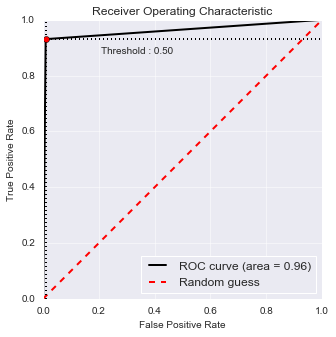

In [111]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 26

In [112]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=50, batch_size=128, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_26 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_27 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 1.18871, saving model to classification_model.h5

Epoch 00002: val_loss improved from 1.1

In [113]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

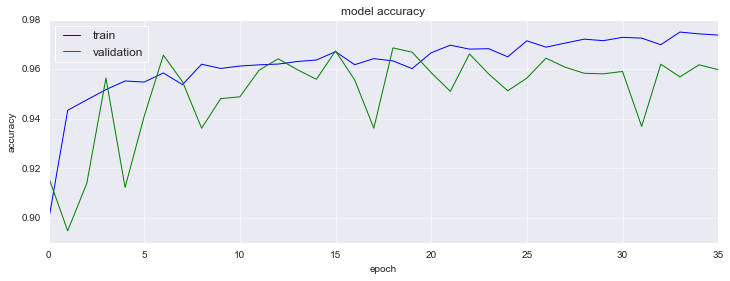

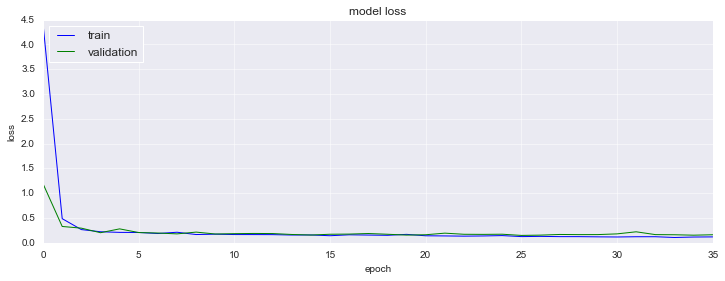

In [114]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [115]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.968, Test: 0.987


In [116]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12524   140]
 [   32   300]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9867651585103109
ROC AUC: 0.9462797494463008
------------------------------------------------------------
Precisión por clase: [0.99745142 0.68181818]
Sensibilidad - Recall por clase: [0.98894504 0.90361446]
F1 por clase: [0.99318002 0.77720207]
------------------------------------------------------------
F1 Macro: 0.885191044199644
F1 Micro: 0.9867651585103109
F1 Weighted: 0.9876625737872702
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9462797494463007
Sensibilidad - Recall Micro: 0.9867651585103109
Sensibilidad - Recall Weighted: 0.9867651585103109
------------------------------------------------------------
Precisión Macro: 0.8396347997335573
Precisión Micro: 0.9867651585103109
Precisión Weighted: 0.9893881493897907
------------------------------------------------------------
Verdaderos positivos - True Positives: 300
Verdadero

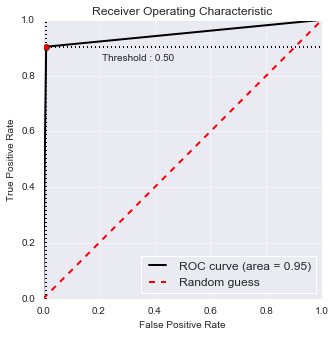

In [117]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [118]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [119]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12530   134]
 [   26   306]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9876885195444752
ROC AUC: 0.9555527860018723
------------------------------------------------------------
Precisión por clase: [0.99792928 0.69545455]
Sensibilidad - Recall por clase: [0.98941883 0.92168675]
F1 por clase: [0.99365583 0.79274611]
------------------------------------------------------------
F1 Macro: 0.8932009713485063
F1 Micro: 0.9876885195444752
F1 Weighted: 0.9885233244532746
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9555527860018723
Sensibilidad - Recall Micro: 0.9876885195444752
Sensibilidad - Recall Weighted: 0.9876885195444752
------------------------------------------------------------
Precisión Macro: 0.8466919111471516
Precisión Micro: 0.9876885195444752
Precisión Weighted: 0.9902021599714992
------------------------------------------------------------
Verdaderos positivos - True Positives: 306
Verdader

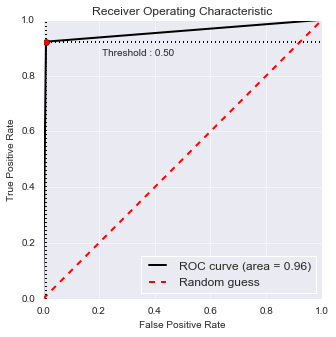

In [120]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 27

In [122]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=50, batch_size=64, validation_split=0.1, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_30 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_31 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.26033, saving model to classification_model.h5

Epoch 00002: val_loss improved from 0.2

In [123]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

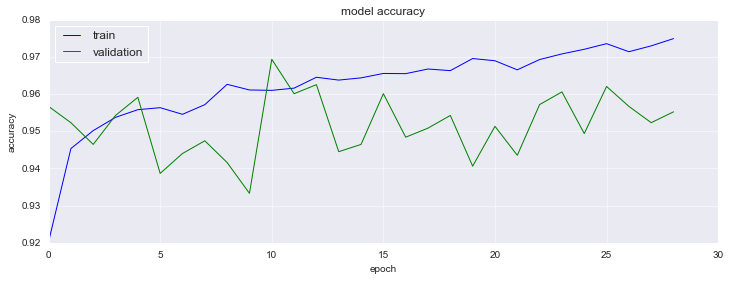

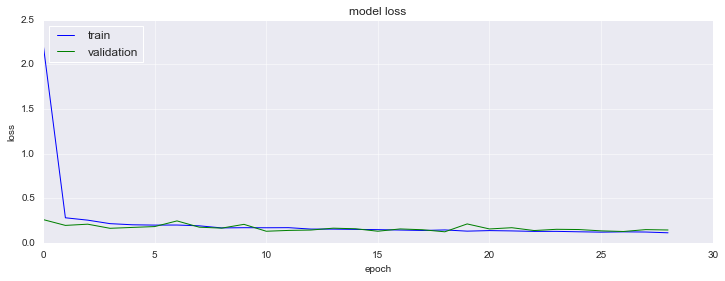

In [124]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [125]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.977, Test: 0.991


In [126]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12576    88]
 [   34   298]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9906124961526623
ROC AUC: 0.9453207650564355
------------------------------------------------------------
Precisión por clase: [0.99730373 0.77202073]
Sensibilidad - Recall por clase: [0.99305117 0.89759036]
F1 por clase: [0.9951729  0.83008357]
------------------------------------------------------------
F1 Macro: 0.9126282352106152
F1 Micro: 0.9906124961526623
F1 Weighted: 0.9909554795449795
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9453207650564355
Sensibilidad - Recall Micro: 0.9906124961526623
Sensibilidad - Recall Weighted: 0.9906124961526623
------------------------------------------------------------
Precisión Macro: 0.8846622262946178
Precisión Micro: 0.9906124961526623
Precisión Weighted: 0.9915485751075601
------------------------------------------------------------
Verdaderos positivos - True Positives: 298
Verdader

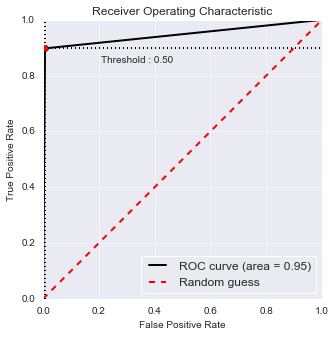

In [127]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [128]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [129]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12547   117]
 [   28   304]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9888427208371807
ROC AUC: 0.9532119317446666
------------------------------------------------------------
Precisión por clase: [0.99777336 0.72209026]
Sensibilidad - Recall por clase: [0.99076121 0.91566265]
F1 por clase: [0.99425492 0.80743692]
------------------------------------------------------------
F1 Macro: 0.9008459209637143
F1 Micro: 0.9888427208371807
F1 Weighted: 0.9894824100627577
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9532119317446666
Sensibilidad - Recall Micro: 0.9888427208371807
Sensibilidad - Recall Weighted: 0.9888427208371807
------------------------------------------------------------
Precisión Macro: 0.8599318105618072
Precisión Micro: 0.9888427208371807
Precisión Weighted: 0.9907306706503299
------------------------------------------------------------
Verdaderos positivos - True Positives: 304
Verdader

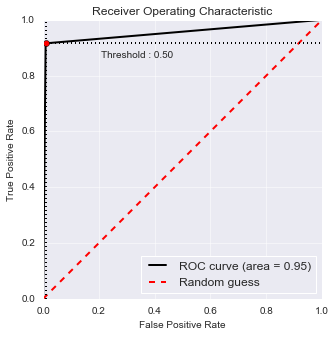

In [130]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 28

In [131]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=100, batch_size=128, validation_split=0.2, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_32 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_33 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 1.22052, saving model to classification_model.h5

Epoch 00002: val_loss improved from 1.2

In [132]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

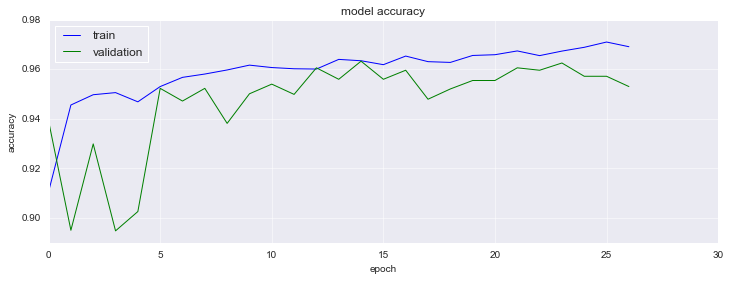

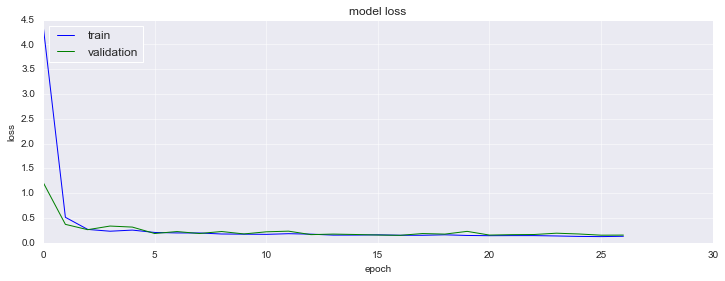

In [133]:
history_plot('acc', 'val_acc', 'model accuracy', 'accuracy', 'epoch')
history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

In [134]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.961, Test: 0.985


In [135]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12491   173]
 [   21   311]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9850723299476762
ROC AUC: 0.9615431086316207
------------------------------------------------------------
Precisión por clase: [0.99832161 0.64256198]
Sensibilidad - Recall por clase: [0.98633923 0.93674699]
F1 por clase: [0.99229425 0.7622549 ]
------------------------------------------------------------
F1 Macro: 0.8772745752257052
F1 Micro: 0.9850723299476762
F1 Weighted: 0.986417589284108
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9615431086316206
Sensibilidad - Recall Micro: 0.9850723299476762
Sensibilidad - Recall Weighted: 0.9850723299476762
------------------------------------------------------------
Precisión Macro: 0.8204417973621356
Precisión Micro: 0.9850723299476762
Precisión Weighted: 0.9892332612667654
------------------------------------------------------------
Verdaderos positivos - True Positives: 311
Verdadero

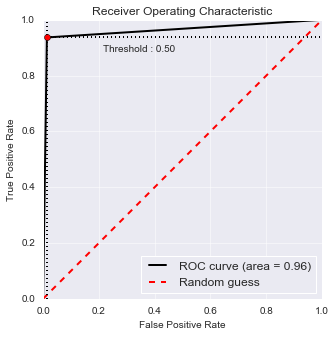

In [136]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [137]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [138]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12552   112]
 [   39   293]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9883810403200985
ROC AUC: 0.9368430766654743
------------------------------------------------------------
Precisión por clase: [0.99690255 0.72345679]
Sensibilidad - Recall por clase: [0.99115603 0.88253012]
F1 por clase: [0.99402099 0.79511533]
------------------------------------------------------------
F1 Macro: 0.8945681591860715
F1 Micro: 0.9883810403200985
F1 Weighted: 0.9889396780819704
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9368430766654743
Sensibilidad - Recall Micro: 0.9883810403200985
Sensibilidad - Recall Weighted: 0.9883810403200985
------------------------------------------------------------
Precisión Macro: 0.8601796697817665
Precisión Micro: 0.9883810403200985
Precisión Weighted: 0.9899170160380204
------------------------------------------------------------
Verdaderos positivos - True Positives: 293
Verdader

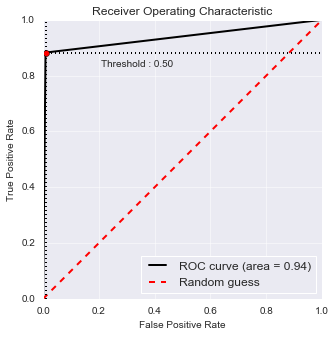

In [139]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

### Modelo 29

In [13]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=40, batch_size=64, validation_split=0.1, verbose=2, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 70)            26600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 70)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                12120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable

In [132]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

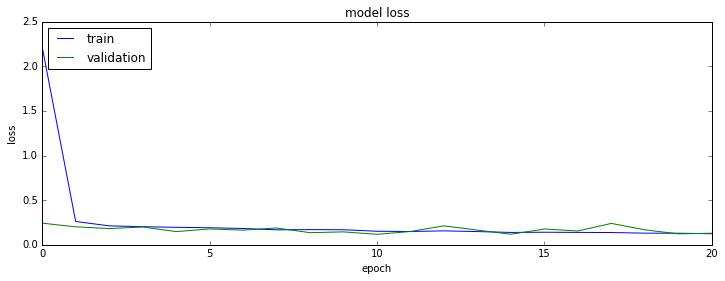

In [14]:

history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

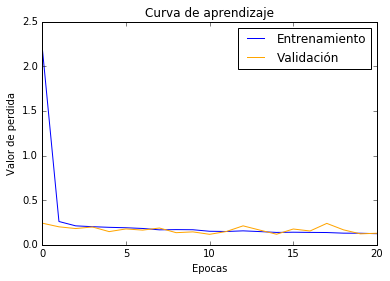

In [19]:
fig_acc = plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], color= 'blue')
plt.plot(history.history['val_loss'],color= 'orange' )
plt.title('Curva de aprendizaje')
plt.ylabel('Valor de perdida')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.savefig('stacked5.png')
pyplot.show()

In [134]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.961, Test: 0.985


In [135]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12491   173]
 [   21   311]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9850723299476762
ROC AUC: 0.9615431086316207
------------------------------------------------------------
Precisión por clase: [0.99832161 0.64256198]
Sensibilidad - Recall por clase: [0.98633923 0.93674699]
F1 por clase: [0.99229425 0.7622549 ]
------------------------------------------------------------
F1 Macro: 0.8772745752257052
F1 Micro: 0.9850723299476762
F1 Weighted: 0.986417589284108
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9615431086316206
Sensibilidad - Recall Micro: 0.9850723299476762
Sensibilidad - Recall Weighted: 0.9850723299476762
------------------------------------------------------------
Precisión Macro: 0.8204417973621356
Precisión Micro: 0.9850723299476762
Precisión Weighted: 0.9892332612667654
------------------------------------------------------------
Verdaderos positivos - True Positives: 311
Verdadero

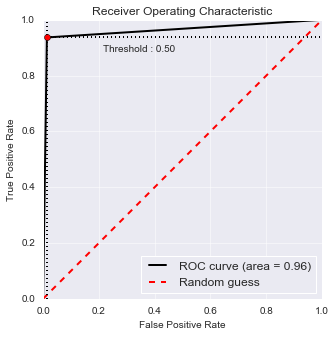

In [136]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [137]:
# cargar el mejor modelo guardado durante el entrenamiento

from keras.models import load_model
# load the saved model
saved_model = load_model('classification_model.h5')

In [138]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12552   112]
 [   39   293]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9883810403200985
ROC AUC: 0.9368430766654743
------------------------------------------------------------
Precisión por clase: [0.99690255 0.72345679]
Sensibilidad - Recall por clase: [0.99115603 0.88253012]
F1 por clase: [0.99402099 0.79511533]
------------------------------------------------------------
F1 Macro: 0.8945681591860715
F1 Micro: 0.9883810403200985
F1 Weighted: 0.9889396780819704
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9368430766654743
Sensibilidad - Recall Micro: 0.9883810403200985
Sensibilidad - Recall Weighted: 0.9883810403200985
------------------------------------------------------------
Precisión Macro: 0.8601796697817665
Precisión Micro: 0.9883810403200985
Precisión Weighted: 0.9899170160380204
------------------------------------------------------------
Verdaderos positivos - True Positives: 293
Verdader

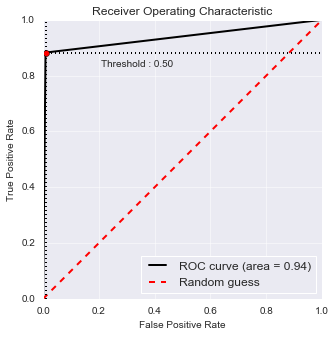

In [139]:
# model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)